In [1]:
import time
import json  # for checkpointing
import csv

from collections import Counter

from pathlib import Path

import numpy as np
import scipy.sparse
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
from tqdm.notebook import trange, tqdm

import pandas as pd

import datetime

import os
from dotenv import load_dotenv, find_dotenv

from timeit import default_timer as timer

load_dotenv(find_dotenv('config.env'))

torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.is_available()

import sklearn
import sklearn.metrics
import seaborn as sns

In [2]:
np.set_printoptions(precision=0, suppress=True, linewidth=160)

## Foreword about PyTorch Version
This notebook is designed to be used with **PyTorch 1.7.1**. 

However, future versions 
In PyTorch version **1.9.0 and newer** (which is at the time of writing still **unstable**), new parameters such as `batch_first` in `torch.nn.MultiheadAttention` are available, which can make it easier to configure the model creation.

In [3]:
print("Loaded PyTorch Version: {}".format(torch.__version__))

Loaded PyTorch Version: 1.7.1


### Needed Library: `svgutils 0.3.1`
**NOTE:** Install svgutils version 0.3.1, newer version will crash our code.

In [ ]:
!conda install -y svgutils=0.3.1 -c conda-forge

### Dotenv

In [ ]:
!conda install -y -c conda-forge python-dotenv

# PLOT PAGES
### https://seaborn.pydata.org/examples/index.html
### https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
### https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f

In [4]:
diverging_palette_dark = sns.diverging_palette(250, 15, s=75, l=40, n=2, center="dark")
diverging_palette_light = sns.diverging_palette(240, 10, n=2, center="light")
diverging_palette_heatmap = sns.color_palette("icefire", as_cmap=True)

display(diverging_palette_dark)
display(diverging_palette_light)
display(diverging_palette_heatmap)

[(0.20651240887022015, 0.3755393698154809, 0.5856904756194529),
 (0.6565296443848212, 0.21867290090002556, 0.1744737357010414)]

[(0.2564697186166857, 0.4871591358142198, 0.657003695890986),
 (0.8545371341681446, 0.22957019267094914, 0.2762321841840895)]

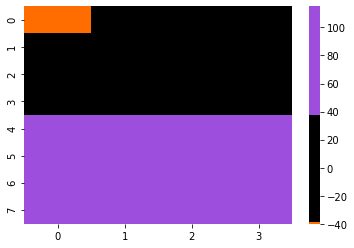

In [5]:
# heatmap_diverge = sns.diverging_palette(350, 50, l=40, n=10, center="light", as_cmap=True)
# display(heatmap_diverge)
test_p = sns.color_palette(["#ff6d00","#000000","#9d4edd"])
x = np.arange(-40, 120, 5).reshape(8, 4)
ax = sns.heatmap(x, center=0, cmap=test_p)

In [6]:
# PLOT PAGES
# 

# for p in sns.palettes.SEABORN_PALETTES:
#     print(p)
#     sns.set_palette(p)
#     sns.palplot(sns.color_palette())
#     plt.show()

In [7]:
# sns.set_style("ticks")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")
# sns.set_style("darkgrid")

sns.set_palette('bright')

In [8]:
def cuda_status_print():
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print("Total:     {:>4.1f} GB".format(round(torch.cuda.get_device_properties(0).total_memory / 1024 ** 3, 1)))
    print('Allocated: {:>4.1f} GB'.format(round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1)))
    print('Cached:    {:>4.1f} GB'.format(round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1)))

In [9]:
!nvidia-smi

Tue Jun  1 08:51:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:E7:00.0 Off |                    0 |
| N/A   35C    P0    48W / 350W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
ticks_tiles_newlined = [
    "1\nman",
    "2\nman",
    "3\nman",
    "4\nman",
    "5\nman",
    "6\nman",
    "7\nman",
    "8\nman",
    "9\nman",
    "1\npin",
    "2\npin",
    "3\npin",
    "4\npin",
    "5\npin",
    "6\npin",
    "7\npin",
    "8\npin",
    "9\npin",
    "1\nsou",
    "2\nsou",
    "3\nsou",
    "4\nsou",
    "5\nsou",
    "6\nsou",
    "7\nsou",
    "8\nsou",
    "9\nsou",
    "\nEast",
    "\nSouth",
    "\nWest",
    "\nNorth",
    "\nHaku",
    "\nHatsu",
    "\nChun"
]

ticks_tiles_oneline = [
    "1 man",
    "2 man",
    "3 man",
    "4 man",
    "5 man",
    "6 man",
    "7 man",
    "8 man",
    "9 man",
    "1 pin",
    "2 pin",
    "3 pin",
    "4 pin",
    "5 pin",
    "6 pin",
    "7 pin",
    "8 pin",
    "9 pin",
    "1 sou",
    "2 sou",
    "3 sou",
    "4 sou",
    "5 sou",
    "6 sou",
    "7 sou",
    "8 sou",
    "9 sou",
    "East",
    "South",
    "West",
    "North",
    "Haku",
    "Hatsu",
    "Chun"
]

In [151]:
##############################################
# PARAMETERS
##############################################
torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device("cuda")
EPOCHS = 30
DATASET_CONFIG = 'final_big'
SHUFFLE_DATASET = True

LOAD_TEST_DATASET_ONLY = False

cuda_status_print()

Tesla V100-SXM3-32GB
Memory Usage:
Total:     31.7 GB
Allocated:  0.4 GB
Cached:     0.6 GB


In [152]:
from enum import Enum

class DiscardDataset(torch.utils.data.Dataset):
    
    class DiscardType(Enum):
        DISCARD = 0
        POOL    = 1

    def __init__(self, data_path, years: list, n_rows: int = None, phase: int = None, balance_data: bool = False, discard_type=DiscardType.DISCARD, singular=False):
        """ 
        If n_rows = None -> get all 
        param: singular: If True, pick 1 state per game at random!
        """ 
        
        # FORCE SEED
        torch.manual_seed(0)
        np.random.seed(0)
        
        # Invalid Parameter Combinations
        if balance_data:
            if not n_rows:
                raise BaseException("`n_rows` must be defined if `balance_data` is True!")
            elif n_rows < 34:
                raise BaseException("Cannot balance data if `n_rows` < 34!")
        
        ALL_YEARS = (2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019)
        invalid_years = set(years) - set(ALL_YEARS)
        if invalid_years:
            raise Exception(f"INVALID YEARS: {invalid_years}")
        
        # Dataset Print
        if n_rows:
            print(f"Loading Dataset with {n_rows:>13,} rows", end=' ')
        else:
            print(f"Loading Dataset with all rows", end=' ')

        if phase in [0, 1, 2]:
            print(f"(Phase {phase})", end=' ')
        else:
            print(f"(All Phases)", end=' ')
            
        print("{:<14}".format("<BALANCED>" if balance_data else '<NOT BALANCED>'), end=' ')
        
        print(years)
        
        # Check if given discard_type is valid
        if discard_type not in [DiscardDataset.DiscardType.DISCARD, DiscardDataset.DiscardType.POOL]:
            raise BaseException(f"INVALID discard type = {discard_type}! Use either `DiscardDataset.DISCARD` or `DiscardDataset.POOL`!")
        self.discard_type = discard_type

        game_id_list = []
        temp_matrices = []
        finished = False
        
        # Used when balance_data = False and n_rows != None
        loaded_rows = 0  
        
        # Used when balance_data = True
        class_bins = np.zeros(34)
        baseline_bin_size = n_rows // 34 if balance_data else -1  # The expected size of the smallest bin

        if balance_data:
            paths_load_bar = tqdm(total=baseline_bin_size * 34, unit='rows', position=0)
        else:
            paths_load_bar = tqdm(total=n_rows, unit='rows', position=0)

        for year in years:

            paths = (Path(data_path) / str(year)).iterdir()

            for idx, path in enumerate(paths):
                
                if path.suffix != '.npz':
                    continue
                
                game_id_list.append(path.stem)

                arr = scipy.sparse.load_npz(path).toarray()  # Loads a single complete game

                if phase in [0, 1, 2]:
                    phased_matrices = self.generate_phase_column(arr)
                    arr = phased_matrices[phase]
                    
                if singular:
                    if arr.shape[0] <= 0:  # No rows found (This can happen if a game lack states from a certain phase)
                        continue
                    random_row_index = np.random.choice(arr.shape[0], 1, replace=False)
                    arr = arr[random_row_index]  # Select 1 row per loaded game

                temp_matrices.append(arr)

                paths_load_bar.set_postfix(year=year, files_loaded=(idx + 1))  # Update Bar

                if balance_data:
                    
                    class_bins += np.bincount(arr[:, -1], minlength=34)
                    smallest_class_bin = int(np.amin(class_bins))

                    paths_load_bar.n = smallest_class_bin * 34
                    paths_load_bar.refresh()
                    
                    if baseline_bin_size <= smallest_class_bin:
                        finished = True
                        break

                else:
                    paths_load_bar.update(arr.shape[0])
                    
                    if n_rows:
                        loaded_rows += arr.shape[0]
                        if n_rows <= loaded_rows:
                            finished = True
                            break

            if finished:  # Early Stopping
                break

        if not finished and n_rows is not None:
            raise BaseException("`n_rows` is higher than found rows -- Either lower `n_rows` or include more annual datasets!")

        new_game_id_list = []
        for i, t_matrix in enumerate(temp_matrices):
            new_game_id_list.extend([game_id_list[i]] * t_matrix.shape[0])
        new_game_id_list = np.array(new_game_id_list)
        
        if balance_data:
            
            matrix = np.concatenate(temp_matrices, axis=0)
            sorted_indices = np.argsort(matrix[:, -1])
            
            matrix = matrix[sorted_indices]  # Sort rows by last column (the y-value)
            new_game_id_list = new_game_id_list[sorted_indices]
            
            split_indices = np.where(np.diff(matrix[:, -1])!=0)[0]+1  # I was drunk
            sorted_rows = np.array_split(matrix, split_indices)  # Organize rows according to their last column's value into a list
            sorted_game_ids = np.array_split(new_game_id_list, split_indices)
            
            for i in range(len(sorted_rows)):
                sorted_rows[i] = sorted_rows[i][:baseline_bin_size]  # The balancing action
                sorted_game_ids[i] = sorted_game_ids[i][:baseline_bin_size]

            final_arr = np.concatenate(sorted_rows, axis=0)
            final_game_id_list = np.concatenate(sorted_game_ids, axis=0)

        else:
            final_arr = np.vstack(temp_matrices)
            final_game_id_list = new_game_id_list
            
            if n_rows:
                final_arr = final_arr[:n_rows]
                final_game_id_list = final_game_id_list[:n_rows]
                
        # Extract Round Number and Steps from data
        self.round_numbers = final_arr[:, 32].reshape(-1).tolist()
        self.step_numbers  = (final_arr[:, 33] + 128 - 1).reshape(-1).tolist()        
        final_arr[:, 32] = -128  # Reset to padding value
        final_arr[:, 33] = -128  # Reset to padding value

        # Finalize tqdm bar
        paths_load_bar.n = final_arr.shape[0]
        paths_load_bar.last_print_n = final_arr.shape[0]
        paths_load_bar.refresh()
        paths_load_bar.close()
        
        self.game_ids = list(final_game_id_list)
        self.combined_x_data = torch.FloatTensor(final_arr[:, :-1])  # Must be Float it seems
        
        self.x_data = None
        if self.discard_type == DiscardDataset.DiscardType.POOL:
            self.use_pools()
        else:
            self.use_discards()
        
        self.y_data = torch.LongTensor(final_arr[:, -1])  # Must be Long it seems
        
    def use_pools(self):
        self.discard_type = DiscardDataset.DiscardType.POOL
        self.x_data = self.combined_x_data[:, 0:374]

    def use_discards(self):
        self.discard_type = DiscardDataset.DiscardType.DISCARD
        self.x_data = torch.hstack((self.combined_x_data[:, :238], self.combined_x_data[:, 374:]))  # Slice away POOL data
    
    @staticmethod
    def generate_phase_column(array: np.array) -> np.array:
        # Begin with merging all pools together

        merged_discards = array[:, 238:374]  # Pool
        merged_discards = np.sum(merged_discards, axis=1)

        phases = np.zeros([array.shape[0]])  # Early Game
        phases[(24 < merged_discards) & (merged_discards <= 48)] = 1  # Mid Game
        phases[(48 < merged_discards)] = 2  # End Game

        return array[(phases == 0)], array[(phases == 1)], array[(phases == 2)]        

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
#         X = self.x_data[idx, 0:374] if self.discard_type == DiscardDataset.DiscardType.POOL else torch.hstack((self.x_data[idx, :238], self.x_data[idx, 374:]))
        return {
            'game_id': self.game_ids[idx],
            'round': self.round_numbers[idx],
            'step': self.step_numbers[idx],
            'X': self.x_data[idx],
            'y': self.y_data[idx]
        }

# DATASET

In [153]:
# Load from configurations
ds_configs = pd.read_csv('Dataset Configurations.csv', index_col='dataset_name')
selected_config = ds_configs.loc[DATASET_CONFIG]
selected_config

train_size          34000000
validation_size        34000
test_size              68000
batch                     32
phases                    -1
years_training          1100
years_validation          10
years_testing              1
balanced_data            111
Name: final_big, dtype: int64

In [154]:
def get_years(code: str) -> list:
    code = int(f"0b{code:0>11}", 2)
    found_years = []
    for i in range(11):
        if (code >> i) & 1:
            found_years.append(2019 - i)
    found_years.reverse()
    return found_years

In [155]:
def get_balanced_data_options(code: str):
    results = [False, False, False]
    code = int(f"0b{code:0>11}", 2)
    results[0] = code & 0b100 != 0
    results[1] = code & 0b010 != 0
    results[2] = code & 0b001 != 0
    return results

In [156]:
print("\nLOADING DATASETS:\n")

torch.manual_seed(0)
np.random.seed(0)

# Setup of Parameters
DATASET_PATH = Path(os.environ.get('DISCARD_DATASET'))  # Get path  # TODO: FIX TO NEW PATH
BATCH_SIZE = int(selected_config['batch'])  # We must cast it or else it will crash
BALANCED_TRAINING, BALANCED_VALIDATION, BALANCED_TEST = get_balanced_data_options(selected_config['balanced_data'])  # 3 boolean values
PHASES = selected_config['phases']
DISCARD_TYPE = DiscardDataset.DiscardType.POOL
TEST_SINGULAR = True

# Training Dataset
train_dataset = None
train_loader = None
if not LOAD_TEST_DATASET_ONLY:
    train_dataset = DiscardDataset(DATASET_PATH,
                                   n_rows=selected_config['train_size'],
                                   years=get_years(selected_config['years_training']),
                                   phase=PHASES,
                                   balance_data=BALANCED_TRAINING,
                                   discard_type=DISCARD_TYPE
                                  )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

# Validation Dataset
validation_dataset = None
validation_loader = None
if not LOAD_TEST_DATASET_ONLY:
    validation_dataset = DiscardDataset(DATASET_PATH,
                                        n_rows=selected_config['validation_size'],
                                        years=get_years(selected_config['years_validation']),
                                        phase=PHASES,
                                        balance_data=BALANCED_VALIDATION,
                                        discard_type=DISCARD_TYPE,
                                        singular=True
                                       )

    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

# Test Dataset
test_dataset = DiscardDataset(DATASET_PATH, 
                              n_rows=selected_config['test_size'], 
                              years=get_years(selected_config['years_testing']),
                              phase=PHASES,
                              balance_data=BALANCED_TEST,
                              discard_type=DISCARD_TYPE,
                              singular=True
                             )

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=SHUFFLE_DATASET)


LOADING DATASETS:

Loading Dataset with    34,000,000 rows (All Phases) <BALANCED>     [2016, 2017]


  0%|          | 0/34000000 [00:00<?, ?rows/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Loading Dataset with        34,000 rows (All Phases) <BALANCED>     [2018]


  0%|          | 0/34000 [00:01<?, ?rows/s]

Loading Dataset with        68,000 rows (All Phases) <BALANCED>     [2019]


  0%|          | 0/68000 [00:00<?, ?rows/s]

In [157]:
cuda_status_print()

Tesla V100-SXM3-32GB
Memory Usage:
Total:     31.7 GB
Allocated:  0.4 GB
Cached:     0.6 GB


In [178]:
len(train_dataset)

34000000

In [ ]:
len(test_dataset.x_data)

In [ ]:
len(test_dataset.game_ids)

## Invalid Data Checker
On rare occasions, some training cases X may be invalid constructed (e.g. the whole tensor is added 1).

How these corruptions occur is a mystery. If corrupted indices are found, redo the dataset loading!

In [172]:
def count_corrupted_cases(dataset):
    """ Return indices of corrupted X datas. """
    if dataset is not None:
        return torch.nonzero(torch.sum(dataset.x_data[:, 68:102], dim=1) > 14).flatten().tolist()
    else:
        return []

corrupt_datasets = [count_corrupted_cases(train_dataset), count_corrupted_cases(validation_dataset), count_corrupted_cases(test_dataset)]
print(f"""Corrupted Dataset Indices:
    - Training Dataset:   {corrupt_datasets[0]}
    - Validation Dataset: {corrupt_datasets[1]}
    - Testing Dataset:    {corrupt_datasets[2]}
""")

assert len(corrupt_datasets[0]) == 0 and len(corrupt_datasets[1]) == 0 and len(corrupt_datasets[2]) == 0

Corrupted Dataset Indices:
    - Training Dataset:   []
    - Validation Dataset: []
    - Testing Dataset:    []



# Phase Datasets Generation

In [159]:
# Early Phase Dataset
phase_datasets = [
    DiscardDataset(DATASET_PATH, 
                   n_rows=34_000, 
                   years=[2015],
                   phase=N,
                   balance_data=True,
                   discard_type=DiscardDataset.DiscardType.POOL,
                   singular=True
                  ) 
    for N in range(3)
]


phase_dataset_loaders = [
    torch.utils.data.DataLoader(phase_dataset, batch_size=1, shuffle=SHUFFLE_DATASET) for phase_dataset in phase_datasets
]

Loading Dataset with        34,000 rows (Phase 0) <BALANCED>     [2015]


  0%|          | 0/34000 [00:00<?, ?rows/s]

Loading Dataset with        34,000 rows (Phase 1) <BALANCED>     [2015]


  0%|          | 0/34000 [00:00<?, ?rows/s]

Loading Dataset with        34,000 rows (Phase 2) <BALANCED>     [2015]


  0%|          | 0/34000 [00:00<?, ?rows/s]

## Round Phase Counter

In [173]:
def round_phase_count(ds):
    
    if ds is None:
        return
    
    pool_counts = ds.x_data[:, 238:374].sum(dim=1)
    early = (pool_counts <= 24).sum()
    mid = ((24 < pool_counts) & (pool_counts <= 48)).sum()
    late = (48 < pool_counts).sum()
    
    print(f"Early Phase: {early}")
    print(f"  Mid Phase: {mid}")
    print(f" Late Phase: {late}")
    
    print(f"LaTeX: {early:,} & {mid:,} & {late:,}")
    
    

print(f"Training Dataset")
round_phase_count(train_dataset)

print(f"\nValidation Dataset")
round_phase_count(validation_dataset)

print(f"\nTesting Dataset")
round_phase_count(test_dataset)

# Phase Datasets
for i, pds in enumerate(phase_datasets):
    print(f"\nPhase Dataset {i}")
    round_phase_count(pds)

Training Dataset
Early Phase: 17239627
  Mid Phase: 12795128
 Late Phase: 3965245
LaTeX: 17,239,627 & 12,795,128 & 3,965,245

Validation Dataset
Early Phase: 17462
  Mid Phase: 12751
 Late Phase: 3787
LaTeX: 17,462 & 12,751 & 3,787

Testing Dataset
Early Phase: 34935
  Mid Phase: 25499
 Late Phase: 7566
LaTeX: 34,935 & 25,499 & 7,566

Phase Dataset 0
Early Phase: 34000
  Mid Phase: 0
 Late Phase: 0
LaTeX: 34,000 & 0 & 0

Phase Dataset 1
Early Phase: 0
  Mid Phase: 34000
 Late Phase: 0
LaTeX: 0 & 34,000 & 0

Phase Dataset 2
Early Phase: 0
  Mid Phase: 0
 Late Phase: 34000
LaTeX: 0 & 0 & 34,000


## Number of Valid Classes Distribution

,n_valid_classes,training_count,validation_count,testing_count,phase_0_count,phase_1_count,phase_2_count
0,0,0,0,0,0,0,0
1,1,47,0,0,0,0,1
2,2,7845,10,18,6,11,34
3,3,114933,127,219,32,167,270
4,4,318664,320,621,93,479,770
5,5,463980,472,935,194,654,959
6,6,970986,952,1830,497,1361,1846
7,7,1580104,1483,2943,956,2091,2959
8,8,2173605,2061,4112,1550,2713,3671
9,9,3855827,3782,7512,3258,4545,5337


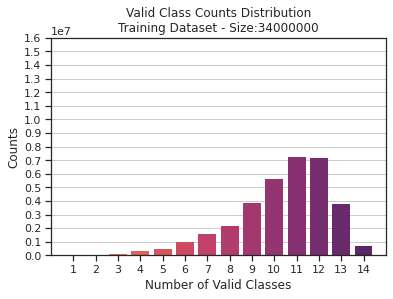

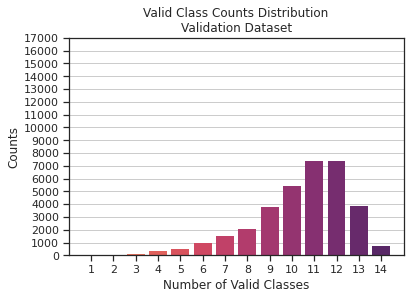

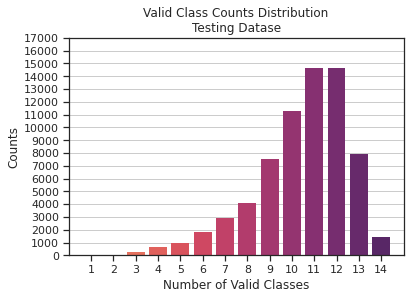

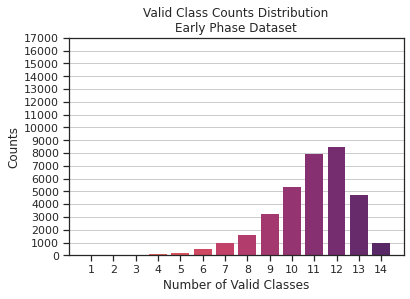

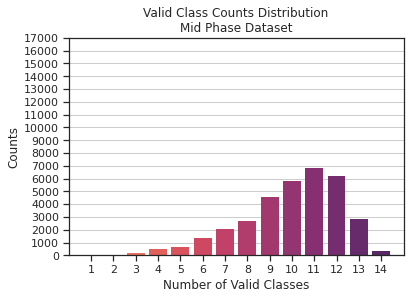

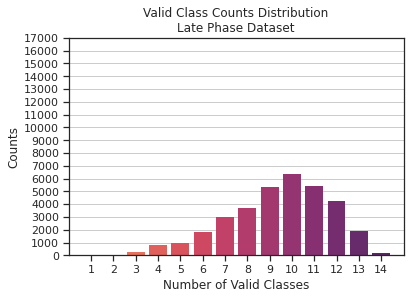

In [174]:
def get_valid_counts(dataset, column_name):
    n_valid, frequency   = np.unique(torch.sum(dataset.x_data[:, 68:102].bool(), dim=1).numpy(), return_counts=True)
    
    data = pd.DataFrame({
        "n_valid_classes": n_valid,
        column_name: frequency
    })
    data = data.set_index('n_valid_classes')
    data = data.reindex(np.arange(0, 14 + 1, dtype=int), fill_value=0)
    
    return data


def display_valid_class_distribution(df, count_column, title):
    # https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot
    # http://alanpryorjr.com/visualizations/seaborn/countplot/countplot/
    sns.set(style="ticks", font_scale=1)
    ax = sns.barplot(data=df,
                     x="n_valid_classes", 
                     y=count_column,
                     palette="flare",
                     saturation=10,
                     edgecolor=(0,0,0),
                     linewidth=0,)

    plt.title(title)
    plt.xlabel('Number of Valid Classes')
    plt.ylabel('Counts')
    
    plt.grid(axis='y')
    
    plt.xlim(0, 15)
    plt.xticks(range(1, 15))
    
    
    if df[count_column].max() <= 34000:
        plt.yticks(np.arange(0, 18000, 1000))
        ax.ticklabel_format(axis='y', style='plain')
    else:
        plt.yticks(np.arange(0, 17_000_000, 1_000_000))


    plt.show()

    
inversion_count_df = pd.concat([
    get_valid_counts(train_dataset      , "training_count"),
    get_valid_counts(validation_dataset , "validation_count"),
    get_valid_counts(test_dataset       , "testing_count"),
    get_valid_counts(phase_datasets[0]  , "phase_0_count"),
    get_valid_counts(phase_datasets[1]  , "phase_1_count"),
    get_valid_counts(phase_datasets[2]  , "phase_2_count"),
], axis=1).reset_index()

display(inversion_count_df)

display_valid_class_distribution(inversion_count_df, "training_count",   f"Valid Class Counts Distribution\nTraining Dataset - Size:{inversion_count_df['training_count'].sum()}")
display_valid_class_distribution(inversion_count_df, "validation_count", f"Valid Class Counts Distribution\nValidation Dataset")
display_valid_class_distribution(inversion_count_df, "testing_count",    f"Valid Class Counts Distribution\nTesting Datase")
display_valid_class_distribution(inversion_count_df, "phase_0_count",    f"Valid Class Counts Distribution\nEarly Phase Dataset")
display_valid_class_distribution(inversion_count_df, "phase_1_count",    f"Valid Class Counts Distribution\nMid Phase Dataset")
display_valid_class_distribution(inversion_count_df, "phase_2_count",    f"Valid Class Counts Distribution\nLate Phase Dataset")

In [179]:
inversion_count_df

,n_valid_classes,training_count,validation_count,testing_count,phase_0_count,phase_1_count,phase_2_count
0,0,0,0,0,0,0,0
1,1,47,0,0,0,0,1
2,2,7845,10,18,6,11,34
3,3,114933,127,219,32,167,270
4,4,318664,320,621,93,479,770
5,5,463980,472,935,194,654,959
6,6,970986,952,1830,497,1361,1846
7,7,1580104,1483,2943,956,2091,2959
8,8,2173605,2061,4112,1550,2713,3671
9,9,3855827,3782,7512,3258,4545,5337


In [181]:
inversion_count_df_cp = inversion_count_df.iloc[1:].copy()
inversion_count_df_cp = inversion_count_df_cp.drop(columns=['n_valid_classes'])
inversion_count_df_cp = inversion_count_df_cp.rename(columns={
    'training_count'  : 'Small Training Set',
    'validation_count': 'Validation Set',
    'testing_count'   : 'Default Test Set',
    'phase_0_count'   : 'Early Phase Set',
    'phase_1_count'   : 'Mid Phase Set',
    'phase_2_count'   : 'Late Phase Set',
})


inversion_count_df_cp = inversion_count_df_cp.T

inversion_count_df_cp['Total'] = [34_000_000, 34000, 68000, 34000, 34000, 34000]

inversion_count_df_cp = inversion_count_df_cp.T

display(inversion_count_df_cp)

print(inversion_count_df_cp.to_latex(formatters=[lambda x: f"{x:,}" for i in range(inversion_count_df_cp.shape[1])]))

,Small Training Set,Validation Set,Default Test Set,Early Phase Set,Mid Phase Set,Late Phase Set
1,47,0,0,0,0,1
2,7845,10,18,6,11,34
3,114933,127,219,32,167,270
4,318664,320,621,93,479,770
5,463980,472,935,194,654,959
6,970986,952,1830,497,1361,1846
7,1580104,1483,2943,956,2091,2959
8,2173605,2061,4112,1550,2713,3671
9,3855827,3782,7512,3258,4545,5337
10,5590652,5450,11247,5336,5799,6361


\begin{tabular}{lrrrrrr}
\toprule
{} & Small Training Set & Validation Set & Default Test Set & Early Phase Set & Mid Phase Set & Late Phase Set \\
\midrule
1     &                 47 &              0 &                0 &               0 &             0 &              1 \\
2     &              7,845 &             10 &               18 &               6 &            11 &             34 \\
3     &            114,933 &            127 &              219 &              32 &           167 &            270 \\
4     &            318,664 &            320 &              621 &              93 &           479 &            770 \\
5     &            463,980 &            472 &              935 &             194 &           654 &            959 \\
6     &            970,986 &            952 &            1,830 &             497 &         1,361 &          1,846 \\
7     &          1,580,104 &          1,483 &            2,943 &             956 &         2,091 &          2,959 \\
8     &          2,173,6

## Dataset Class Distribution

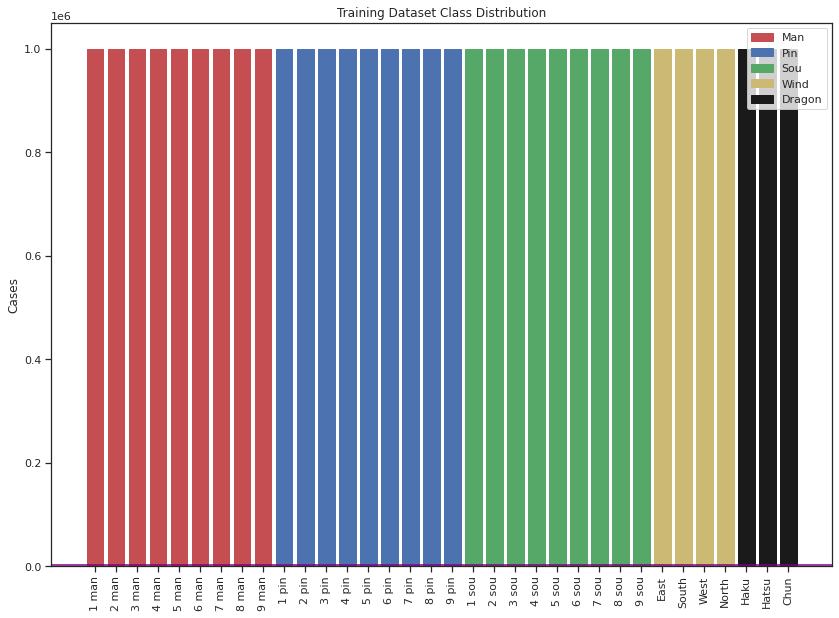

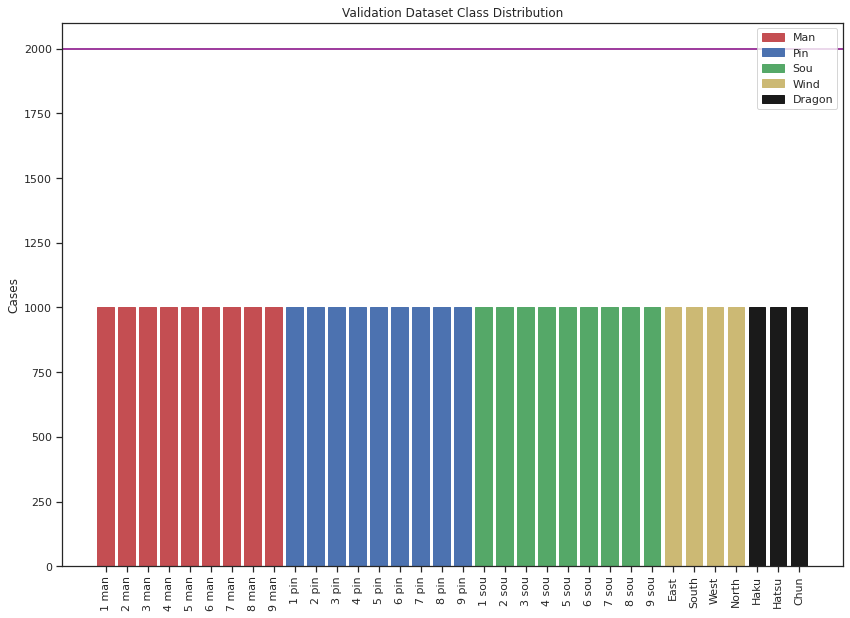

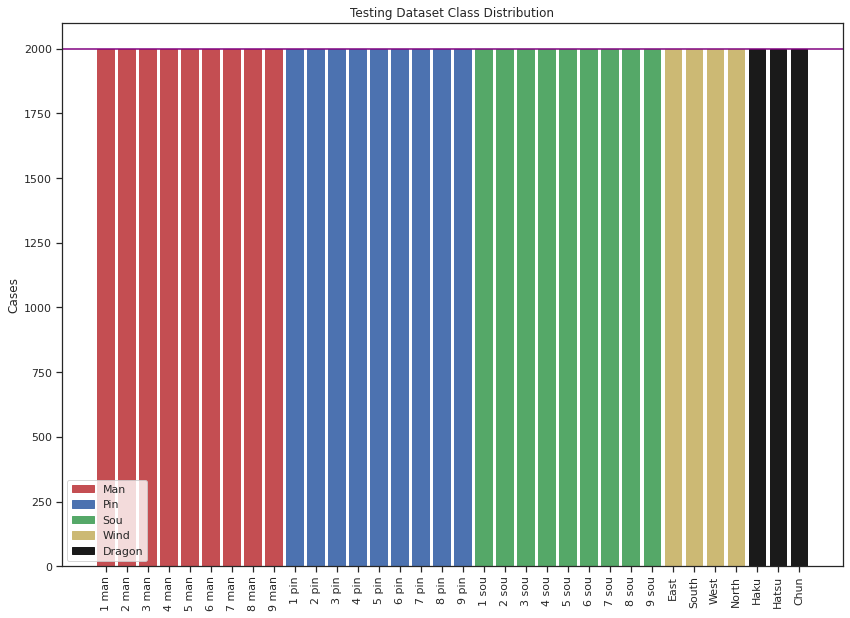

PHASE DATASETS


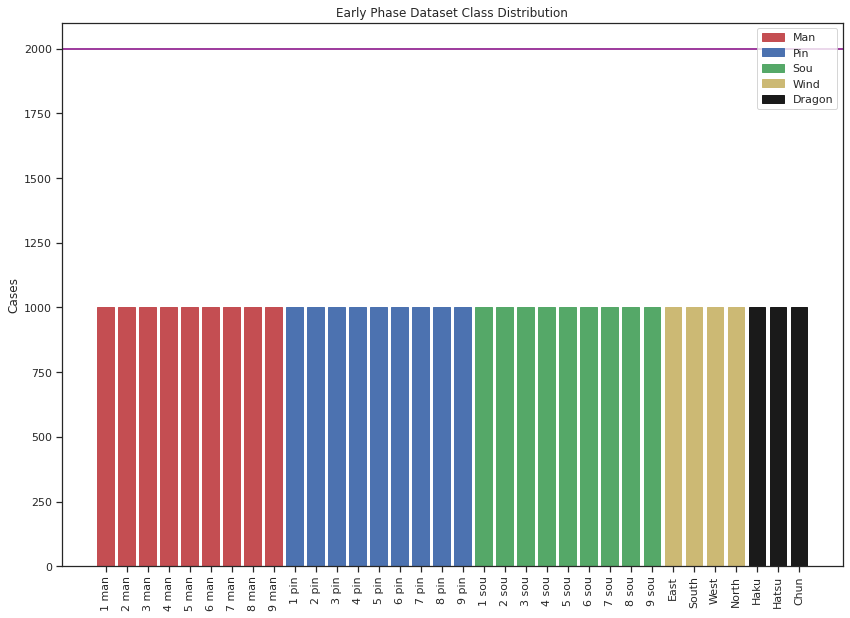

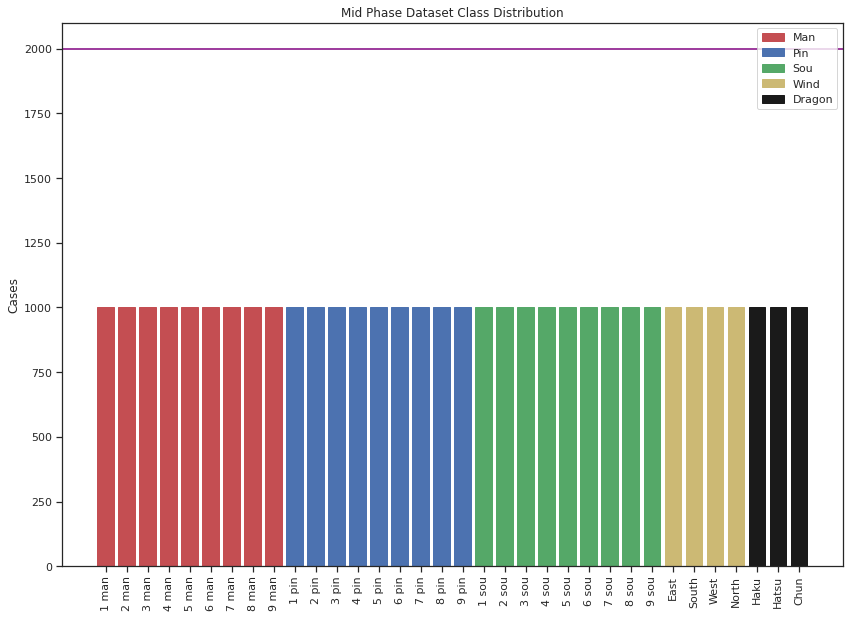

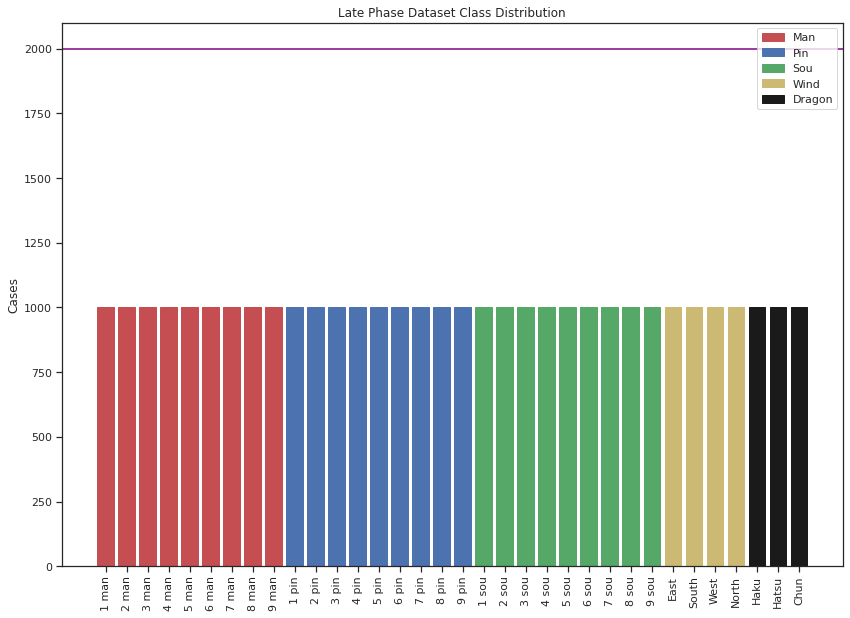

In [177]:
def generate_dataset_class_distribution(Y, title: str, horizontal=False):
    
    keys, counts = np.unique(Y, return_counts=True)
    fig = plt.figure(figsize=(14, 10))

    bar_list = None
    if not horizontal:
        bar_list = plt.bar(keys, counts)
        plt.xticks(range(34), ticks_tiles_oneline, rotation=90)
        plt.ylabel("Cases")
    else:
        bar_list = plt.barh(keys, counts)
        plt.yticks(range(34), ticks_tiles_oneline, rotation=0)
        plt.xlabel("Cases")

    for i in range(0, 9):
        bar_list[i].set_color('r')

    for i in range(9, 18):
        bar_list[i].set_color('b')

    for i in range(18, 27):
        bar_list[i].set_color('g')

    for i in range(27, 31):
        bar_list[i].set_color('y')

    for i in range(31, 34):
        bar_list[i].set_color('k')

    ax = plt.gca()
    legend_man = mpatches.Patch(color='r', label='Man')
    legend_pin = mpatches.Patch(color='b', label='Pin')
    legend_sou = mpatches.Patch(color='g', label='Sou')
    legend_wind = mpatches.Patch(color='y', label='Wind')
    legend_dragons = mpatches.Patch(color='k', label='Dragon')
    
    plt.axhline(y=2000, alpha=1, color='purple', linestyle='-')  # TEMPORARY


    plt.title(title)
    plt.legend(handles=[legend_man, legend_pin, legend_sou, legend_wind, legend_dragons])

    plt.show()

generate_dataset_class_distribution(train_dataset.y_data, "Training Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(validation_dataset.y_data, "Validation Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(test_dataset.y_data, "Testing Dataset Class Distribution", horizontal=False)

print('PHASE DATASETS')
generate_dataset_class_distribution(phase_datasets[0].y_data, "Early Phase Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(phase_datasets[1].y_data, "Mid Phase Dataset Class Distribution", horizontal=False)
generate_dataset_class_distribution(phase_datasets[2].y_data, "Late Phase Dataset Class Distribution", horizontal=False)

# Model Creation

## Basic Network

In [26]:
class Net(torch.nn.Module):
    """ Simple Feed-Forward Net """

    def __init__(self):
        super(Net, self).__init__()
        
        self.name = "BasicDenseNetwork_testing"
        
        self.fc1 = torch.nn.Linear(11 * 34, 1024)  # SWITCH TO 1024
        self.fc2 = torch.nn.Linear(1024, 512)      # SWITCH TO 1024
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()

    def forward(self, x):
            
        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)

        return x

In [27]:
class AttentiveNet(torch.nn.Module):
    """ Multihead Attention Layer into simple feed-forward net. """

    def __init__(self):
        super(AttentiveNet, self).__init__()
        
        self.name = "AttentiveNet"
        
        self.mha1 = torch.nn.MultiheadAttention(embed_dim=374, 
                                                num_heads=34,  # 1, 11, or 34 are doable
                                                dropout=0.0,   # Default: 0.0.
                                                add_zero_attn=True,  # Default: False
                                               )

        self.fc1 = torch.nn.Linear(11 * 34, 1028)   # SWITCH TO 1024
        self.fc2 = torch.nn.Linear(1028, 512)       # SWITCH TO 1024
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()

    def forward(self, x):
        
        batch_size = x.shape[0]
        x = x.reshape(1, batch_size, 374)  #  => x.shape[0] = Batch Size
        attn_output, attn_output_weights = self.mha1(query=x, key=x, value=x, need_weights=False)  # attn_output_weights = None, if need_weights=False
        x = (x * attn_output).reshape(batch_size, 374)

        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)

        return x

In [28]:
class BigNet(torch.nn.Module):
    """ Attention Layer into Bigger feed-forward net. """

    def __init__(self):
        super(BigNet, self).__init__()
        
        self.name = "BigFeedForward"
        
        self.fc1 = torch.nn.Linear(11 * 34, 4096)   # EXTRA LAYER
        self.fc2 = torch.nn.Linear(4096, 2048)      # EXTRA LAYER
        self.fc3 = torch.nn.Linear(2048, 1024)
        self.fc4 = torch.nn.Linear(1024, 512)
        self.fc5 = torch.nn.Linear(512, 256)
        self.fc6 = torch.nn.Linear(256, 128)
        self.fc7 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()
        self.relu_5 = torch.nn.LeakyReLU()
        self.relu_6 = torch.nn.LeakyReLU()


    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)
        x = self.relu_5(x)
        
        x = self.fc6(x)
        x = self.relu_6(x)
        
        x = self.fc7(x)
        
        return x

In [29]:
class BigAttentionNet(torch.nn.Module):
    """ Attention Layer into Bigger feed-forward net. """

    def __init__(self, n_heads):
        super(BigAttentionNet, self).__init__()
        
        self.name = f"MHA-{n_heads}"
#         print(self.name)
        
        self.mha1 = torch.nn.MultiheadAttention(embed_dim=374, 
                                                num_heads=n_heads,  # 1, 11, or 34 are doable
                                                dropout=0.0,   # Default: 0.0.
                                                add_zero_attn=False,  # Default: False - Have this false, from not so many experiments, it seems like it slows down learning accuracy by a almost unoticeable bit
                                               )

        self.fc1 = torch.nn.Linear(11 * 34, 4096)   # EXTRA LAYER
        self.fc2 = torch.nn.Linear(4096, 2048)      # EXTRA LAYER
        self.fc3 = torch.nn.Linear(2048, 1024)
        self.fc4 = torch.nn.Linear(1024, 512)
        self.fc5 = torch.nn.Linear(512, 256)
        self.fc6 = torch.nn.Linear(256, 128)
        self.fc7 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()
        self.relu_5 = torch.nn.LeakyReLU()
        self.relu_6 = torch.nn.LeakyReLU()


    def forward(self, x):
        
        batch_size = x.shape[0]
        x = x.reshape(1, batch_size, 374)  #  => x.shape[0] = Batch Size
        attn_output, attn_output_weights = self.mha1(query=x, key=x, value=x, need_weights=False)  # attn_output_weights = None, if need_weights=False
        x = (x * attn_output).reshape(batch_size, 374)

        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)
        x = self.relu_5(x)
        
        x = self.fc6(x)
        x = self.relu_6(x)
        
        x = self.fc7(x)
        
        return x

In [30]:
class TESTNET(torch.nn.Module):
    """ Attention Layer into Bigger feed-forward net. """

    def __init__(self, n_heads):
        super(TESTNET, self).__init__()
        
        self.name = f"MHA-{n_heads}"
#         print(self.name)
        
        self.mha1 = torch.nn.MultiheadAttention(embed_dim=374, 
                                                num_heads=n_heads,  # 1, 11, or 34 are doable
                                                dropout=0.0,   # Default: 0.0.
                                                add_zero_attn=False,  # Default: False - Have this false, from not so many experiments, it seems like it slows down learning accuracy by a almost unoticeable bit
                                               )

        self.fc1 = torch.nn.Linear(11 * 34, 4096)   # EXTRA LAYER
        self.fc2 = torch.nn.Linear(4096, 2048)      # EXTRA LAYER
        self.fc3 = torch.nn.Linear(2048, 1024)
        self.fc4 = torch.nn.Linear(1024, 512)
        self.fc5 = torch.nn.Linear(512, 256)
        self.fc6 = torch.nn.Linear(256, 128)
        self.fc7 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()
        self.relu_5 = torch.nn.LeakyReLU()
        self.relu_6 = torch.nn.LeakyReLU()


    def forward(self, x):
        
        batch_size = x.shape[0]
        x = x.reshape(3, batch_size, 374)  #  => x.shape[0] = Batch Size
        attn_output, attn_output_weights = self.mha1(query=x, key=x, value=x, need_weights=False)  # attn_output_weights = None, if need_weights=False
        
        breakpoint()
        x = (x * attn_output).reshape(batch_size, 374)

        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)
        x = self.relu_5(x)
        
        x = self.fc6(x)
        x = self.relu_6(x)
        
        x = self.fc7(x)
        
        return x

### Model Selection

In [31]:
torch.manual_seed(0)
np.random.seed(0)

model = BigAttentionNet(1).to(DEVICE)  # SWITCH ATTENTION
# model = BigNet().to(DEVICE)

criterion = torch.nn.CrossEntropyLoss().to(DEVICE)  # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loaded_epoch = 0

model

BigAttentionNet(
  (mha1): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=374, out_features=374, bias=True)
  )
  (fc1): Linear(in_features=374, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=34, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.01)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (relu_4): LeakyReLU(negative_slope=0.01)
  (relu_5): LeakyReLU(negative_slope=0.01)
  (relu_6): LeakyReLU(negative_slope=0.01)
)

In [32]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params

13279242

In [ ]:
LOAD_FOLDER = "MHA-1-FINAL-SMALL-2021-05-14"  # Change this to None do NOT want to load anything, otherwise a string to designated model-folder

# TO LOAD OR NOT LOAD
if LOAD_FOLDER:
    CHECKPOINT_PATH = Path('model_checkpoints') / LOAD_FOLDER
    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
    INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
    INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
    HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

    last_epoch_file = sorted([c for c in CHECKPOINT_PATH.iterdir() if c.suffix == '.pt'])[-1]
    loaded_checkpoint = torch.load(last_epoch_file)
    print('Loaded Epoch', loaded_checkpoint['epoch'])

    model.load_state_dict(loaded_checkpoint['model_state'])
    optimizer.load_state_dict(loaded_checkpoint['optimizer_state'])
    loaded_epoch = loaded_checkpoint['epoch']

else:
    # Create Model Checkpoint Folder
    timestamp_string = time.strftime('%Y-%m-%d_%H-%M', time.localtime(time.time()))
    CHECKPOINT_PATH = Path('model_checkpoints') / f"{timestamp_string}_{model.name}"
    CHECKPOINT_PATH.mkdir()

    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
    INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
    INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
    HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

    model_desc_json = {
        'model_name': model.name,
        'model_description': repr(model),
        'dataset_config': repr(selected_config)
    }

    with open(DESCRIPTION_PATH, 'w') as outfile:
        json.dump(model_desc_json, outfile)

    with open(SUMMARY_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", 
                         "train_loss", 
                         "train_acc", 
                         "train_average_valid_weight_sum", 
                         "train_average_weight_per_valid_class", 
                         "train_average_weight_per_invalid_class", 
                         "val_loss", 
                         "val_acc", 
                         "val_average_valid_weight_sum", 
                         "val_average_weight_per_valid_class", 
                         "val_average_weight_per_invalid_class",
                         "time_elapsed"])
    
    with open(INVERSION_STATS_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["mode",
                         "epoch",
                         "n_valid",
                         "min", 
                         "max", 
                         "mean", 
                         "median",])
        
    inversion_count_df.to_csv(INVERSION_COUNTS_PATH, index=False)
    
    with open(HEATMAP_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        heatmap_fieldnames = ["mode", "epoch", "n_valid"] + [f'h_{i}' for i in range(34)]
        writer.writerow(heatmap_fieldnames)

# TRAINING & VALIDATION

In [ ]:
def seconds_to_hhmmss(s):
    seconds = s
    minutes = seconds // 60
    hours = minutes // 60
    return "%02d:%02d:%02d" % (hours, minutes % 60, seconds % 60)

In [ ]:
def get_discard_weight_sum_metrics(hands, logits):
    """ 
    Calculates different weight sum metrics.
    Note: TensorShape of both params must be equal!

    Args:
        hands (Tensor): POV hands as tensor. Expected shape: [b, 34] where b is batch size
        logits (Tensor): logits as tensor. Expected shape: [b, 34] where b is batch size

    Returns:
        tuple(Float, Float): 
            0. First value is the average weight sum of valid discards.
            1. Second value is the average weight sum of valid discards divided by number of valid discard classes.
    """
    
    class_distributions = F.softmax(logits, dim=1)  # Convert logits into distribution that sums to 1
    masked = hands.bool() * class_distributions  # Mask tensorwise, where invalid classes => 0.
    num_valid_classes = torch.sum(hands.bool(), dim=1)
    sum_valid_weight_sum = torch.sum(masked, dim=1)  # Sum() each row

    # Batch Averages
    avg_batch_weight_sum = torch.mean(sum_valid_weight_sum).item()
    avg_batch_weight_sum_per_class = torch.mean(sum_valid_weight_sum / num_valid_classes).item()
    avg_batch_weight_sum_per_class_invalid = torch.mean((1 - sum_valid_weight_sum) / (34 - num_valid_classes)).item()
    
    return avg_batch_weight_sum, avg_batch_weight_sum_per_class, avg_batch_weight_sum_per_class_invalid

In [ ]:
def generate_sorted_binary_valid_class_tensors(hands, logits):
    return torch.gather(hands.bool(), dim=1, index=torch.argsort(logits, dim=1, descending=True))

In [ ]:
def generate_inversion_rows(mode: str, epoch: int, n_valids: np.array, binary_valids: np.array) -> list:
    
    assert mode == 'training' or mode == 'validation', f"ILLEGAL MODE: {mode}"
    
    # Count Inversions Formula
    # all_inversion_counts = torch.sum(
    #    torch.cumsum(binary_valids.bitwise_not(), dim=1) * binary_valids, 
    #    dim=1
    # )
    
    # Conversion: [Tensor -> np.array] Reason: Removes overhead from GPU memory TODO: NO NEED AS WE WILL DO THE CONVERSION OUTSIDE
#     n_valids = n_valids.cpu().numpy()  
#     binary_valids = binary_valids.cpu().numpy()
    
    all_inversion_counts = (np.bitwise_not(binary_valids).cumsum(axis=1) * binary_valids).sum(axis=1)  # Count inversions of binary arrays
    
    inversion_dict_list = []
    for n_valid in range(1, 15):
        mask = n_valids == n_valid
        if True in mask:  # False if mask does not find matching tensors
            arr = all_inversion_counts[mask]  # Masked inversion counts tensor      
            inversion_dict_list.append({
                 "mode": 0 if mode == 'training' else 1,
                 "epoch": epoch,
                 "n_valid": n_valid,
                 "min": np.amin(arr), 
                 "max": np.amax(arr), 
                 "mean": np.mean(arr), 
                 "median": np.median(arr),
            })
        else:
            inversion_dict_list.append({
                 "mode": 0 if mode == 'training' else 1,
                 "epoch": epoch,
                 "n_valid": n_valid,
                 "min": np.NAN, 
                 "max": np.NAN, 
                 "mean": np.NAN, 
                 "median": np.NAN,
            })

    return inversion_dict_list

In [ ]:
def generate_heatmap_rows(mode: str, epoch: int, n_valids: np.array, binary_valids: np.array) -> np.array:
    
    assert mode == 'training' or mode == 'validation', f"ILLEGAL MODE: {mode}"
    
    # Heat-values setup
    heat_array = np.full((14, 34), fill_value=np.NAN)  # 2D np.array
    for n_valid in range(1, 15):
        mask = n_valids == n_valid
        if True in mask:  # False if mask does not find matching tensors
            masked_arrays = binary_valids[mask, :]
            heat_array[n_valid - 1] = np.sum(masked_arrays, axis=0) / masked_arrays.shape[0]  # Get average frequency of valid bit for each position
    
    # Metadata columns
    mode_column = np.zeros((14, 1), dtype=np.uint8) if mode == 'training' else np.ones((14, 1), dtype=np.uint8)
    epoch_column = np.full((14, 1), fill_value=epoch)
    n_valid_column = np.arange(start=1, stop=15, dtype=np.uint8).reshape(14, 1)
    
    return np.concatenate((mode_column, epoch_column, n_valid_column, heat_array), axis=1)

In [ ]:
if loaded_epoch != 0:
    loaded_epoch += 1  # If epoch was loaded
    
# Print Dataset Discard Format
print("Training Dataset Discard-Format:   {}".format(train_dataset.discard_type))
print("Validation Dataset Discard-Format: {}".format(validation_dataset.discard_type))
print("Test Dataset Discard-Format:       {}".format(test_dataset.discard_type))

# Progress Bars
mq = trange(EPOCHS, desc='EPOCH', unit='epoch', initial=loaded_epoch)
tq = trange(len(train_loader), desc=f'TRAINING', unit='batch', mininterval=0.5)
vq = trange(len(validation_loader), desc=f'VALIDATION', unit='batch')


for epoch in range(loaded_epoch, EPOCHS):
    
    torch.manual_seed(epoch)
    start_timer = timer()  # Start timer
    
    ##############################################
    # TRAINING
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0
    sum_valid_discard_weight_sum = 0.0
    sum_valid_discard_weight_sum_per_tile = 0.0
    sum_invalid_discard_weight_sum_per_tile = 0.0

    binary_valid_tensors = []  # For Inversion & Heatmap calculation
    
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(X)  # Outputs float values for each class (do softmax on `outputs` to get distribution)
        
        # Loss Calculation
        loss = criterion(outputs, y)  # avg loss in batch -> No need for softmax if criterion = Cross Entropy Loss
        sum_epoch_loss += loss.item()

        # Accuracy Calculation
        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size
        sum_epoch_acc += batch_acc
        
        # Calculate Valid/Invalid Discards weights
        avg_vwsum, avg_vwsum_per_class, avg_iwsum_per_class = get_discard_weight_sum_metrics(hands=X[:, 68:102], logits=outputs)
        sum_valid_discard_weight_sum += avg_vwsum  # Mean() each row into final `valid weight average`
        sum_valid_discard_weight_sum_per_tile += avg_vwsum_per_class
        sum_invalid_discard_weight_sum_per_tile += avg_iwsum_per_class
        
        # Calculate Number of Inversios
        binary_valid_tensors.append(generate_sorted_binary_valid_class_tensors(hands=X[:, 68:102], logits=outputs))

        # Batch Clean-up
        loss.backward()  # compute gradients
        optimizer.step()  # update weights
        
        tq.update(1)
        
    tq.refresh()
    time.sleep(0.1)
    
    # Training Summary Calculations
    avg_acc_train = sum_epoch_acc / len(train_loader)  # average accuracy
    avg_loss_train = sum_epoch_loss / len(train_loader)  # average loss
    avg_valid_discard_weight_sum_train = sum_valid_discard_weight_sum / len(train_loader)  # average valid weight
    sum_valid_discard_weight_sum_per_tile_train = sum_valid_discard_weight_sum_per_tile / len(train_loader)
    sum_invalid_discard_weight_sum_per_tile_train = sum_invalid_discard_weight_sum_per_tile / len(train_loader)
    
    ### INVERSION & HEATMAP Calculation
    binary_valid_tensors = torch.cat(binary_valid_tensors).cpu().numpy()  # Nested 2D PyTorch Tensors => Single 2D NumPy Array
    n_valid_classes = binary_valid_tensors.sum(axis=1)
    inversion_rows_train = generate_inversion_rows('training', epoch, n_valid_classes, binary_valid_tensors)
    heatmap_rows_train = generate_heatmap_rows('training', epoch, n_valid_classes, binary_valid_tensors)
        
    ##############################################
    # VALIDATION
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0
    sum_valid_discard_weight_sum = 0.0
    sum_valid_discard_weight_sum_per_tile = 0.0
    sum_invalid_discard_weight_sum_per_tile = 0.0
    
    binary_valid_tensors = []  # For Inversion & Heatmap calculation

    model.eval()
    for batch_idx, batch in enumerate(validation_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        # optimizer.zero_grad()  # TODO: Needed?

        with torch.no_grad():  # Disables tracking of gradient
            outputs = model(X)
            
        # Loss Calculation
        loss = criterion(outputs, y)  # avg loss in batch
        sum_epoch_loss += loss.item()

        # Accuracy Calculation
        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size
        sum_epoch_acc += batch_acc
        
        # Calculate Valid/Invalid Discards weights
        avg_vwsum, avg_vwsum_per_class, avg_iwsum_per_class = get_discard_weight_sum_metrics(hands=X[:, 68:102], logits=outputs)
        sum_valid_discard_weight_sum += avg_vwsum  # Mean() each row into final `valid weight average`
        sum_valid_discard_weight_sum_per_tile += avg_vwsum_per_class
        sum_invalid_discard_weight_sum_per_tile += avg_iwsum_per_class
        
        # Calculate Number of Inversions
        binary_valid_tensors.append(generate_sorted_binary_valid_class_tensors(hands=X[:, 68:102], logits=outputs))
        
        vq.update(1)
    
    vq.refresh()
    time.sleep(0.1)
    
    # Training Summary Calculations
    avg_acc_val = sum_epoch_acc / len(validation_loader)  # average accuracy
    avg_loss_val = sum_epoch_loss / len(validation_loader)  # average loss
    avg_valid_discard_weight_sum_val = sum_valid_discard_weight_sum / len(validation_loader)  # average valid weight
    sum_valid_discard_weight_sum_per_tile_val = sum_valid_discard_weight_sum_per_tile / len(validation_loader)
    sum_invalid_discard_weight_sum_per_tile_val = sum_invalid_discard_weight_sum_per_tile / len(validation_loader)
    
    ### INVERSION & HEATMAP Calculation
    binary_valid_tensors = torch.cat(binary_valid_tensors).cpu().numpy()  # Nested 2D PyTorch Tensors => Single 2D NumPy Array
    n_valid_classes = binary_valid_tensors.sum(axis=1)
    inversion_rows_val = generate_inversion_rows('validation', epoch, n_valid_classes, binary_valid_tensors)
    heatmap_rows_val = generate_heatmap_rows('validation', epoch, n_valid_classes, binary_valid_tensors)
    
    ##############################################
    # EPOCH CLEAN-UP
    ##############################################
    elapsed_time = timer() - start_timer  # End Timer
    
    # Print Epoch Summary
    print('EPOCH {:>2}  |  TRAIN: loss={:.3f}, acc={:5.3f}, vwsum={:5.3f} -> valid/invalid={:5.3f}/{:5.3f} |  VALIDATION: loss={:.3f}, acc={:5.3f}, vwsum={:5.3f} -> valid/invalid={:5.3f}/{:5.3f}  | TIME ELAPSED: {}'
          .format(epoch,
                  avg_loss_train, 
                  avg_acc_train,
                  avg_valid_discard_weight_sum_train,
                  sum_valid_discard_weight_sum_per_tile_train,
                  sum_invalid_discard_weight_sum_per_tile_train,
                  avg_loss_val, 
                  avg_acc_val,
                  avg_valid_discard_weight_sum_val,
                  sum_valid_discard_weight_sum_per_tile_val,
                  sum_invalid_discard_weight_sum_per_tile_val,
                  seconds_to_hhmmss(elapsed_time),
                 ))
    
    # Save Epoch Summary to csv
    with open(SUMMARY_PATH, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch, 
            avg_loss_train,
            avg_acc_train,
            avg_valid_discard_weight_sum_train,
            sum_valid_discard_weight_sum_per_tile_train,
            sum_invalid_discard_weight_sum_per_tile_train,
            avg_loss_val,
            avg_acc_val,
            avg_valid_discard_weight_sum_val,
            sum_valid_discard_weight_sum_per_tile_val,
            sum_invalid_discard_weight_sum_per_tile_val,
            seconds_to_hhmmss(elapsed_time)
        ])
        
    with open(INVERSION_STATS_PATH, 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["mode","epoch","n_valid","min", "max", "mean", "median",])
        writer.writerows(inversion_rows_train + inversion_rows_val)
    
    # Heatmap to .csv
    heatmap_combined_np = np.concatenate((heatmap_rows_train, heatmap_rows_val), axis=0)
    heatmap_df = pd.DataFrame(heatmap_combined_np)
    heatmap_df.to_csv(HEATMAP_PATH, mode='a', header=False, index=False, na_rep='NaN')
        
    # Checkpoint Creation
    training_checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
    }

    destination = CHECKPOINT_PATH / (f'epoch-{epoch:03}.pt')
    torch.save(training_checkpoint, destination)
    
    # Progress Bar Clean-up
    mq.update(1)
    tq.reset()
    vq.reset()

# Model TESTING

## Load Model for Testing

In [165]:
# LOAD_MODEL_FOLDER = "MHA-1-SUPHX-2021-05-13"          # 15 000 000 Training
# LOAD_MODEL_FOLDER = "MHA-34-POOL-NEW-2021-05-11"      # 34 000 000 Training
# LOAD_MODEL_FOLDER = "MHA-34-POOL-BALANCED-2021-05-08" # 34 000 000 Training

# LOAD_MODEL_FOLDER = "MHA-1-FINAL-BIG-2021-05-14"  # 34 000 000 Training
# LOAD_MODEL_FOLDER = "MHA-1-FINAL-SMALL-2021-05-14"  # 17 000 000 Training
# LOAD_MODEL_FOLDER = "FFO-FINAL-BIG-2021-05-15"  # 17 000 000 Training

model_paths = {
    'FFO-B': Path('model_checkpoints') / "FFO-FINAL-BIG-2021-05-15",
    'MHA-B': Path('model_checkpoints') / "MHA-1-FINAL-BIG-2021-05-14",
    'MHA-S': Path('model_checkpoints') / "MHA-1-FINAL-SMALL-2021-05-14",
}

models = {}

# LOAD_EPOCH_NUMBER = None  # If None, select epoch with lowest val_loss

for model_name, checkpoint_path in model_paths.items():
    
    summary_df = pd.read_csv(checkpoint_path / 'summary.csv').dropna()
    lowest_val_loss_id = summary_df['val_loss'].idxmin()
    loaded_checkpoint = torch.load(checkpoint_path / f"epoch-{lowest_val_loss_id:03}.pt")
    
# CHECKPOINT_PATH = Path('model_checkpoints') / LOAD_MODEL_FOLDER
# DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
# SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'
# INVERSION_STATS_PATH = CHECKPOINT_PATH / 'inversions.csv'
# INVERSION_COUNTS_PATH = CHECKPOINT_PATH / 'inversions_counts.csv'
# HEATMAP_PATH = CHECKPOINT_PATH / 'heatmap.csv'

# summary_df = pd.read_csv(SUMMARY_PATH).dropna()
# lowest_val_loss_id = summary_df['val_loss'].idxmin()
# loaded_checkpoint = torch.load(CHECKPOINT_PATH / f"epoch-{lowest_val_loss_id:03}.pt")

# loaded_checkpoint = None
# if not LOAD_EPOCH_NUMBER:
#     summary_df = pd.read_csv(SUMMARY_PATH).dropna()
#     lowest_val_loss_id = summary_df['val_loss'].idxmin()
#     loaded_checkpoint = torch.load(CHECKPOINT_PATH / f"epoch-{lowest_val_loss_id:03}.pt")
# else:
#     loaded_checkpoint = torch.load(CHECKPOINT_PATH / f"epoch-{LOAD_EPOCH_NUMBER:03}.pt")

    torch.manual_seed(0)
    np.random.seed(0)

    # Model Initialization
    model = BigAttentionNet(1).to(DEVICE) if model_name != 'FFO-B' else BigNet().to(DEVICE)
    # model = BigNet().to(DEVICE)
#     criterion = torch.nn.CrossEntropyLoss().to(DEVICE)  # Loss function
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    # Load weights
    model.load_state_dict(loaded_checkpoint['model_state'])
#     optimizer.load_state_dict(loaded_checkpoint['optimizer_state'])
    loaded_epoch = loaded_checkpoint['epoch']

    # Descriptive Print
#     for k, v in json.load((checkpoint_path / 'description.json').open()).items():
#         print(f"{k}: \n{v}\n")
    print(model_name)
    print('Loaded Epoch', loaded_checkpoint['epoch'])
        
    models[model_name] = model

FFO-B
Loaded Epoch 17
MHA-B
Loaded Epoch 15
MHA-S
Loaded Epoch 13


In [166]:
for model_name, model in models.items():
    print(model_name)
    print(model)
    print()

FFO-B
BigNet(
  (fc1): Linear(in_features=374, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=34, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.01)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (relu_4): LeakyReLU(negative_slope=0.01)
  (relu_5): LeakyReLU(negative_slope=0.01)
  (relu_6): LeakyReLU(negative_slope=0.01)
)

MHA-B
BigAttentionNet(
  (mha1): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=374, out_features=374, bias=True)
  )
  (fc1): Linear(in_features=374, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_featu

In [167]:
def top_k_invalid_row(pov_hands: torch.Tensor, sorted_output_indices, model_name, phase_index):
    """ Generates a row of top-k-invalid-discards. """
    
    invalid_discards_counts = []  # Index 0 = Top 1, index 1 = Top2, etc.
    for k in range(1, 15):
        top_N_mask = sorted_output_indices[:, 0:k].reshape(-1, k)            # A column with current predicted indices as rows
        found_values = pov_hands.gather(dim=1, index=top_N_mask)             # Replace predicted indices to number of tiles => each cell = [0, 4]
        invalid_bool_tensor = torch.count_nonzero(found_values, dim=1) != k  # Map column into bool array, True="contains AT LEAST 1 invalid classes"
        invalid_discards_counts.append(invalid_bool_tensor.sum().item())


    # Accuracy of Top Predictions
    keys = [f"top_{i}" for i in range(14)]
    invalid_pairs = dict(zip(keys, invalid_discards_counts))

    row_invalid_discards = {
        "phase": phase_index,
        "model": model_name,
        **invalid_pairs
    }

    return row_invalid_discards

# Testing (Default Dataset)

In [168]:
print('\nTESTING')

DATASET_LOADER = test_loader               # DEFAULT TEST

all_targets = []
all_pov_hands = []

all_output_logits = {}

all_sorted_logits = {}
all_sorted_logits_indices = {}

all_correct_indices = {}

all_predictions = {}

for model_name, model in models.items():
    
    print(model_name)
    
    torch.manual_seed(0)
    np.random.seed(0)

    targets = []
    pov_hands = []  # 2d list
    output_logits = []

    model.eval()
    for batch_idx, batch in enumerate(tqdm(DATASET_LOADER, total=len(DATASET_LOADER), desc=f'Testing', unit='batch')):

        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

    #     optimizer.zero_grad()  # No needed during testing
        with torch.no_grad():
            output = model(X)

        output = output[0]  # output is shape[1, 34] due to batching process, this line undoes it to shape[34]

        output_logits.append(output)
        pov_hands.append(X[0][68:102])
        targets.append(y.item())


    sorted_logits, sorted_logits_indices = torch.sort(torch.vstack(output_logits), descending=True)  # sorted_logits_indices = sorted_prediction_indices
    correct_indices = [c.index(targets[i]) for i, c in enumerate(sorted_logits_indices.tolist())]
    predictions = [p[0].item() for p in sorted_logits_indices]  # Creation of predictions list (deferred for optimization)
    
    all_targets.append(targets)
    all_pov_hands.append(torch.vstack(pov_hands).to(DEVICE))
    
    all_output_logits[model_name] = torch.vstack(output_logits).to(DEVICE)
    all_sorted_logits[model_name] = sorted_logits
    all_sorted_logits_indices[model_name] = sorted_logits_indices
    all_correct_indices[model_name] = correct_indices
    all_predictions[model_name] = predictions
    
    print('Testing Completed!')

    
# Simplify variables
assert all_targets[0] == all_targets[1] == all_targets[2]
assert torch.equal(all_pov_hands[0], all_pov_hands[1]) and torch.equal(all_pov_hands[1], all_pov_hands[2])
targets = all_targets[0]
pov_hands = all_pov_hands[0]


TESTING
FFO-B


Testing:   0%|          | 0/68000 [00:00<?, ?batch/s]

Testing Completed!
MHA-B


Testing:   0%|          | 0/68000 [00:00<?, ?batch/s]

Testing Completed!
MHA-S


Testing:   0%|          | 0/68000 [00:00<?, ?batch/s]

Testing Completed!


### Top-K Invalid Discards (Default)

In [39]:
rows_invalid_discards = []
for model_name, sorted_indices in all_sorted_logits_indices.items():
    row = top_k_invalid_row(pov_hands, sorted_indices, model_name, 'Default')
    rows_invalid_discards.append(row)
    
perfect_minimum = inversion_count_df[f'testing_count'][0:14].tolist()
keys = [f"top_{i}" for i in range(14)]
perfect_invalid_pairs = dict(zip(keys, perfect_minimum))
row_invalid_discards = {
    "phase": 'Default',
    "model": "Minimum",
    **perfect_invalid_pairs
}
rows_invalid_discards.append(row_invalid_discards)
                            
df = pd.DataFrame(rows_invalid_discards)
df

,phase,model,top_0,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,top_11,top_12,top_13
0,Default,FFO-B,102,966,4572,12155,21912,31465,39809,47014,53362,58713,62922,65789,67390,67938
1,Default,MHA-B,1,44,261,1247,3733,8240,15284,24671,35914,48254,58425,64681,67318,67941
2,Default,MHA-S,3,51,312,1324,3811,8254,15331,24740,36156,48524,58590,64802,67353,67953
3,Default,Minimum,0,0,18,219,621,935,1830,2943,4112,7512,11247,14609,14631,7887


In [40]:
dfd = df.copy()

dfd = dfd.set_index(['model'])
dfd = dfd[['top_0', 'top_1', 'top_2', 'top_3', 'top_4']]
dfd = dfd.rename(columns={
    'top_0': 'Top 1', 
    'top_1': 'Top 2',
    'top_2': 'Top 3',
    'top_3': 'Top 4',
    'top_4': 'Top 5'
})


dfd_percentage = (dfd / 68000 * 100)

dfd = dfd.reset_index()
dfd_percentage = dfd_percentage.reset_index()

print(dfd.to_latex(index=False, float_format='%.2f'))
print(dfd_percentage.to_latex(index=False, float_format='%.3f'))

\begin{tabular}{lrrrrr}
\toprule
   model &  Top 1 &  Top 2 &  Top 3 &  Top 4 &  Top 5 \\
\midrule
   FFO-B &    102 &    966 &   4572 &  12155 &  21912 \\
   MHA-B &      1 &     44 &    261 &   1247 &   3733 \\
   MHA-S &      3 &     51 &    312 &   1324 &   3811 \\
 Minimum &      0 &      0 &     18 &    219 &    621 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
   model &  Top 1 &  Top 2 &  Top 3 &  Top 4 &  Top 5 \\
\midrule
   FFO-B &  0.150 &  1.421 &  6.724 & 17.875 & 32.224 \\
   MHA-B &  0.001 &  0.065 &  0.384 &  1.834 &  5.490 \\
   MHA-S &  0.004 &  0.075 &  0.459 &  1.947 &  5.604 \\
 Minimum &  0.000 &  0.000 &  0.026 &  0.322 &  0.913 \\
\bottomrule
\end{tabular}



# TOP K ACCURACY


FFO-B
Top  1 :  0.482
Top  2 :  0.685
Top  3 :  0.792
Top  4 :  0.858
Top  5 :  0.901
Top  6 :  0.931
Top  7 :  0.952
Top  8 :  0.968
Top  9 :  0.980
Top 10 :  0.988
Top 11 :  0.994
Top 12 :  0.997
Top 13 :  0.999
Top 14 :  1.000
Top 15 :  1.000
Top 16 :  1.000
Top 17 :  1.000
Top 18 :  1.000
Top 19 :  1.000
Top 20 :  1.000
LATEX:
 48.22 &  68.54 &  79.17 &  85.83 &  90.08 &  93.09 &  95.23 &  96.79 &  98.02 &  98.78 &  99.35 &  99.70 &  99.88 &  99.95 &  99.97 &  99.99 &  99.99 &  99.99 &  99.99 & 100.00 \\



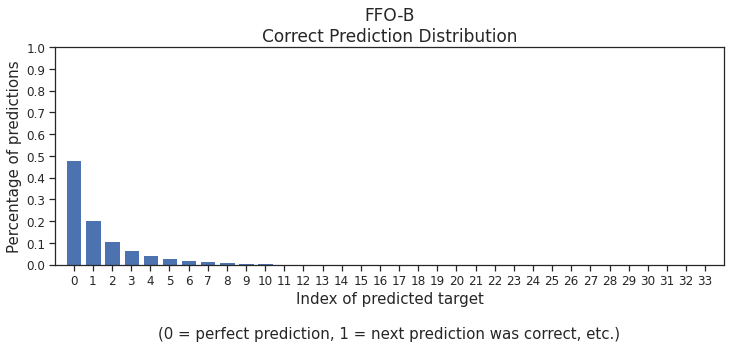


MHA-B
Top  1 :  0.667
Top  2 :  0.858
Top  3 :  0.931
Top  4 :  0.963
Top  5 :  0.980
Top  6 :  0.989
Top  7 :  0.994
Top  8 :  0.996
Top  9 :  0.998
Top 10 :  0.999
Top 11 :  0.999
Top 12 :  1.000
Top 13 :  1.000
Top 14 :  1.000
Top 15 :  1.000
Top 16 :  1.000
Top 17 :  1.000
Top 18 :  1.000
Top 19 :  1.000
Top 20 :  1.000
LATEX:
 66.71 &  85.75 &  93.07 &  96.31 &  97.99 &  98.89 &  99.38 &  99.64 &  99.81 &  99.89 &  99.95 &  99.96 &  99.98 &  99.99 &  99.99 &  99.99 &  99.99 &  99.99 & 100.00 & 100.00 \\



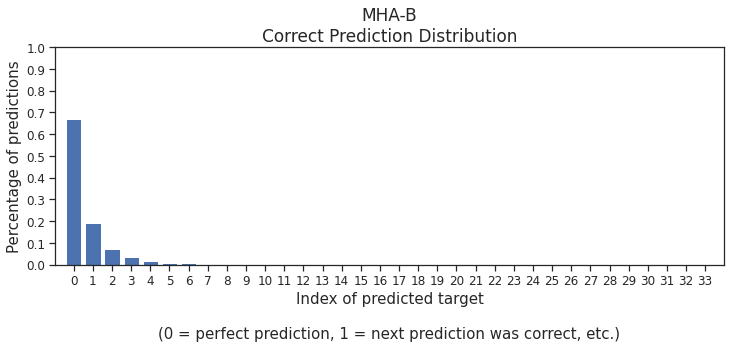


MHA-S
Top  1 :  0.652
Top  2 :  0.846
Top  3 :  0.922
Top  4 :  0.958
Top  5 :  0.976
Top  6 :  0.986
Top  7 :  0.992
Top  8 :  0.996
Top  9 :  0.998
Top 10 :  0.999
Top 11 :  0.999
Top 12 :  1.000
Top 13 :  1.000
Top 14 :  1.000
Top 15 :  1.000
Top 16 :  1.000
Top 17 :  1.000
Top 18 :  1.000
Top 19 :  1.000
Top 20 :  1.000
LATEX:
 65.18 &  84.56 &  92.21 &  95.76 &  97.55 &  98.62 &  99.22 &  99.55 &  99.77 &  99.87 &  99.92 &  99.96 &  99.98 &  99.98 &  99.99 &  99.99 &  99.99 & 100.00 & 100.00 & 100.00 \\



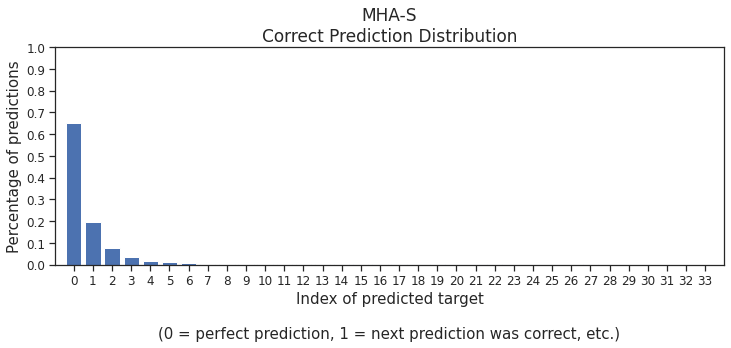

In [41]:
max_k = 20

for model_name in models:
    
    print(f"\n{model_name}")
    
    prediction_correctness = Counter()  # 0 = perfect predictions, 33 = worst prediction case

    for index_of_prediction in all_correct_indices[model_name]:
        prediction_correctness[index_of_prediction] += 1

    # Accuracy of Top Predictions
    top_sums = []
    for i in range(max_k):
        top_sum = 0
        for j in range(i + 1):
            top_sum += prediction_correctness[j]
        top_sums.append(top_sum)
    
    for j, top_sum in enumerate(top_sums):
        acc = top_sum / len(targets)
        print(f"Top {j+1:>2} : {acc:6.3f}")
        
    top_sums = [f"{(s / len(targets)) * 100:6.2f}" for s in top_sums]
    top_sums = top_sums[:max_k]
    print('LATEX:')
    print(" & ".join(top_sums), end=' \\\\')
    print('\n')
    
    
    # Correct Prediction Distribution
    title_fontsize = 17
    ticks_fontsize = 12
    label_fontsize = 15
    legend_fontsize = 13

    plt.figure(figsize=(12, 4))

    plt.bar(prediction_correctness.keys(), [v / len(targets) for v in prediction_correctness.values()])

    plt.ylim(0, 1)
    plt.xlim(-1, 34)

    plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=ticks_fontsize)
    plt.xticks(range(34), fontsize=ticks_fontsize)

    plt.title(f'{model_name}\nCorrect Prediction Distribution', fontsize=title_fontsize)
    plt.xlabel('Index of predicted target\n\n(0 = perfect prediction, 1 = next prediction was correct, etc.)', fontsize=label_fontsize)
    plt.ylabel('Percentage of predictions', fontsize=label_fontsize)

    plt.show()

# Phase Dataset Testing

In [42]:
print('\nTESTING')

rows_invalid_discards = []

rows = []

for model_name, model in models.items():
    
    print(f"\n\n{model_name}")
    
    for phase_index, dataloader in enumerate(phase_dataset_loaders):
    
        torch.manual_seed(0)
        np.random.seed(0)
        
        print(len(dataloader))

        targets = []
        pov_hands = []  # 2d list
        output_logits = []

        model.eval()
        for batch_idx, batch in enumerate(tqdm(dataloader, total=len(dataloader), desc=f'Testing', unit='batch')):

            X = batch['X'].to(DEVICE)
            y = batch['y'].to(DEVICE)

        #     optimizer.zero_grad()  # No needed during testing
            with torch.no_grad():
                output = model(X)

            output = output[0]  # output is shape[1, 34] due to batching process, this line undoes it to shape[34]

            output_logits.append(output)
            pov_hands.append(X[0][68:102])
            targets.append(y.item())


        sorted_logits, sorted_logits_indices = torch.sort(torch.vstack(output_logits), descending=True)  # sorted_logits_indices = sorted_prediction_indices
        correct_indices = [c.index(targets[i]) for i, c in enumerate(sorted_logits_indices.tolist())]
        predictions = [p[0].item() for p in sorted_logits_indices]  # Creation of predictions list (deferred for optimization)
        

    
    
        # K-ACCURACY
        prediction_correctness = Counter()  # 0 = perfect predictions, 33 = worst prediction case
        for index_of_prediction in correct_indices:
            prediction_correctness[index_of_prediction] += 1

        # Accuracy of Top Predictions
        top_sums = []
        for i in range(max_k):
            top_sum = 0
            for j in range(i + 1):
                top_sum += prediction_correctness[j]
            top_sums.append(top_sum)
      
        keys = [f"top_{i}" for i in range(34)]
        top_sums = [s / len(targets) for s in top_sums]
        
        accuracy_pairs = dict(zip(keys, top_sums))
        
        row = {
            "model": model_name,
            "phase": phase_index,
            **accuracy_pairs
        }
        rows.append(row)

        
        
        # Top K Invalid Discard - Row Creation
        pov_hands = torch.vstack(pov_hands)
        row = top_k_invalid_row(pov_hands, sorted_logits_indices, model_name, phase_index)
        rows_invalid_discards.append(row)

for i in range(3):
    perfect_minimum = inversion_count_df[f'phase_{i}_count'][0:14].tolist()
    perfect_invalid_pairs = dict(zip(keys, perfect_minimum))
    row_invalid_discards = {
        "phase": i,
        "model": "Minimum",
        **perfect_invalid_pairs
    }
    rows_invalid_discards.append(row_invalid_discards)

    
df = pd.DataFrame(rows)
df_top_k_invalid = pd.DataFrame(rows_invalid_discards)


TESTING


FFO-B
34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]

34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]

34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]



MHA-B
34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]

34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]

34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]



MHA-S
34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]

34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]

34000


Testing:   0%|          | 0/34000 [00:00<?, ?batch/s]

### K-Discard Beautify

In [43]:
dfy = df_top_k_invalid.copy()
dfy = dfy.sort_values('phase')
dfy['phase'] = dfy['phase'].replace([0, 1, 2], ['Early', 'Mid', 'Late'])
dfy = dfy[['phase', 'model', 'top_0', 'top_1', 'top_2', 'top_3', 'top_4']]

dfy = dfy.rename(columns={
    'top_0': 'Top 1', 
    'top_1': 'Top 2',
    'top_2': 'Top 3',
    'top_3': 'Top 4',
    'top_4': 'Top 5'
})


dfy = dfy.set_index(['phase', 'model'], drop=True)
dfy

Top 1  Top 2  Top 3  Top 4  Top 5
phase model                                     
Early FFO-B       36    450   2673   7347  13312
      MHA-B        2     21    122    486   1547
      MHA-S        2     20    112    481   1444
      Minimum      0      0      6     32     93
Mid   FFO-B       59    470   1752   4444   8515
      MHA-B        1     36    206    881   2470
      MHA-S        2     26    210    898   2542
      Minimum      0      0     11    167    479
Late  FFO-B       57    483   1908   4238   7489
      MHA-B        4     31    160    781   2308
      MHA-S        7     42    216    869   2481
      Minimum      0      1     34    270    770

In [44]:
dfy_percentage = (dfy / 34000 * 100)
print(dfy.to_latex(multirow=True, index=True, float_format='%.2f'))
print(dfy_percentage.to_latex(multirow=True, index=True, float_format='%.3f'))

\begin{tabular}{llrrrrr}
\toprule
     &         &  Top 1 &  Top 2 &  Top 3 &  Top 4 &  Top 5 \\
phase & model &        &        &        &        &        \\
\midrule
\multirow{4}{*}{Early} & FFO-B &     36 &    450 &   2673 &   7347 &  13312 \\
     & MHA-B &      2 &     21 &    122 &    486 &   1547 \\
     & MHA-S &      2 &     20 &    112 &    481 &   1444 \\
     & Minimum &      0 &      0 &      6 &     32 &     93 \\
\cline{1-7}
\multirow{4}{*}{Mid} & FFO-B &     59 &    470 &   1752 &   4444 &   8515 \\
     & MHA-B &      1 &     36 &    206 &    881 &   2470 \\
     & MHA-S &      2 &     26 &    210 &    898 &   2542 \\
     & Minimum &      0 &      0 &     11 &    167 &    479 \\
\cline{1-7}
\multirow{4}{*}{Late} & FFO-B &     57 &    483 &   1908 &   4238 &   7489 \\
     & MHA-B &      4 &     31 &    160 &    781 &   2308 \\
     & MHA-S &      7 &     42 &    216 &    869 &   2481 \\
     & Minimum &      0 &      1 &     34 &    270 &    770 \\
\bottomrule
\end{ta

### K-Accuracy Beautify

In [45]:
dfx = df.copy()
dfx = dfx[['model', 'phase', 'top_0', 'top_1', 'top_2', 'top_3', 'top_4']]

dfx[['top_0', 'top_1', 'top_2', 'top_3', 'top_4']] *= 100

dfx = dfx.rename(columns={
    'top_0': '1st', 
    'top_1': '2nd',
    'top_2': '3rd',
    'top_3': '4th',
    'top_4': '5th'
})

dfx['phase'] = dfx['phase'].replace([0, 1, 2], ['Early', 'Mid', 'Late'])

dfx = dfx.set_index(['model', 'phase'], drop=True)

In [46]:
dfx

1st        2nd        3rd        4th        5th
model phase                                                       
FFO-B Early  49.408824  71.135294  82.500000  88.785294  92.526471
      Mid    48.979412  67.244118  77.300000  83.767647  88.341176
      Late   43.388235  60.111765  70.170588  77.491176  82.941176
MHA-B Early  66.967647  86.967647  93.994118  96.929412  98.358824
      Mid    68.147059  85.776471  92.405882  95.758824  97.558824
      Late   62.152941  80.158824  88.797059  93.620588  96.350000
MHA-S Early  65.926471  85.994118  93.438235  96.544118  98.102941
      Mid    66.620588  84.238235  91.391176  94.961765  97.167647
      Late   61.017647  79.361765  87.955882  92.823529  95.867647

In [47]:
print(dfx.to_latex(multirow=True, index=True, float_format='%.2f'))

\begin{tabular}{llrrrrr}
\toprule
      &      &   1st &   2nd &   3rd &   4th &   5th \\
model & phase &       &       &       &       &       \\
\midrule
\multirow{3}{*}{FFO-B} & Early & 49.41 & 71.14 & 82.50 & 88.79 & 92.53 \\
      & Mid & 48.98 & 67.24 & 77.30 & 83.77 & 88.34 \\
      & Late & 43.39 & 60.11 & 70.17 & 77.49 & 82.94 \\
\cline{1-7}
\multirow{3}{*}{MHA-B} & Early & 66.97 & 86.97 & 93.99 & 96.93 & 98.36 \\
      & Mid & 68.15 & 85.78 & 92.41 & 95.76 & 97.56 \\
      & Late & 62.15 & 80.16 & 88.80 & 93.62 & 96.35 \\
\cline{1-7}
\multirow{3}{*}{MHA-S} & Early & 65.93 & 85.99 & 93.44 & 96.54 & 98.10 \\
      & Mid & 66.62 & 84.24 & 91.39 & 94.96 & 97.17 \\
      & Late & 61.02 & 79.36 & 87.96 & 92.82 & 95.87 \\
\bottomrule
\end{tabular}



## Calculate Invalid Discards Metrics (Superceded)

In [ ]:
# for model_name in models:

#     invalid_discards_dict = {}
#     # hand_tensor = torch.vstack(pov_hands).to(DEVICE)
#     for top_index in range(0, 34):
#         top_N_mask = all_sorted_logits_indices[model_name][:, top_index].reshape(-1, 1)  # Column with current selected indices rowise
#         found_values = pov_hands.gather(dim=1, index=top_N_mask)
#         invalid_discards_dict[top_index] = torch.sum(found_values == 0)

#     # Accuracy of Top Predictions
#     total_invalid_discards = sum(invalid_discards_dict.values()).item()
#     print("TOTAL INVALID DISCARDS:", total_invalid_discards)
#     print("Top K Accumulated Invalid Discards")
#     for i in range(34):
#         top_sum = 0
#         for j in range(i + 1):
#             top_sum += invalid_discards_dict[j]

#         print("Top {:>2}: {:>7.5f}  {:>8}  (+{:>7})".
#               format(i+1,
#                      top_sum / total_invalid_discards,
#                      top_sum,
#                      invalid_discards_dict[i]
#                     ))

#     print("\nTop 1 Summary:")
#     print("- Number of Invalid Discard Prediction: {}".format(invalid_discards_dict[0]))
#     print("- In {} out of {} test cases, or {:.3f}% of all cases, an invalid class was predicted.".format(invalid_discards_dict[0], len(targets), (invalid_discards_dict[0] / len(targets)) * 100))

### Valid / Invalid Discard Weight Sum

##### Valid Tiles vs Valid Classes
An important note is that we should be mindful about the subtle difference between valid **tiles** vs valid **classes**.
A given hand can be in this format: 
```python
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
```
Note that there's 2 tiles of class `21`. 
In this example:
- number of **valid tiles**   = 11
- number of **valid classes** = 10

**Note:** The number of **valid tiles** >= The number of **valid classes**

In [ ]:
for model_name in models:
    avg_ws, avg_ws_valid, avg_ws_invalid = get_discard_weight_sum_metrics(pov_hands, all_output_logits[model_name])

    valid_tiles = torch.sum(pov_hands, dim=1)
    avg_valid_tiles = torch.mean(valid_tiles.float()).item()

    valid_classes = torch.sum(pov_hands.bool(), dim=1)
    avg_valid_classes = torch.mean(valid_classes.float()).item()
    
    print(model_name)
    print(f'Average Valid Weight Sum:             {avg_ws:>6.3f}')
    print(f'Average Weight Sum per Valid Class:   {avg_ws_valid:>6.3f}')
    print(f'Average Weight Sum per Invalid Class: {avg_ws_invalid:>6.3f}')
    print(f'Average Number of Valid Tiles:        {avg_valid_tiles:>6.3f}')
    print(f'Average Number of Valid Classes:      {avg_valid_classes:>6.3f}')
    print()

## More elaborated accuracy metric
- Check if any of top 3 predictions are correct.
- Check if any of the predictions prioritized above target are invalid discards.
    - Note that this only applies if target is not top 1 predicted class.

## Weight Confidence Distribution
Aka. "Average Prediction Weight Density".

In [ ]:

sns.set_style("ticks")
# sns.set_palette('bright')
sns.set_palette(sns.color_palette("hls", 10))

for i, model_name in enumerate(models):
    sorted_output_distribution = F.softmax(all_sorted_logits[model_name], dim=1)
    numpy_distribution = sorted_output_distribution.cpu().detach().numpy()
    avg_distribution = np.mean(numpy_distribution, axis=0)
    print("Top K Propability Confidence Distribution")
    for i in range(34):
        top_sum = 0
        for j in range(i + 1):
            top_sum += avg_distribution[j]

        print(f"Top {i+1:>2}: {top_sum:>8.3f}  (+{avg_distribution[i]:>5.3f})")

    print("\nOn average, the top 1 prediction is allocated {:>5.2f}% of total probability.".format(avg_distribution[0] * 100))
    print("On average, the top 3 predictions are allocated {:>5.2f}% of total probability.".format(sum(avg_distribution[[0,1,2]]) * 100))

plt.figure(figsize=(10, 3))

plt.grid(axis = 'y')

VALUES = 14

width=0.2
for i, model_name in enumerate(models):

    sorted_output_distribution = F.softmax(all_sorted_logits[model_name], dim=1)
    numpy_distribution = sorted_output_distribution.cpu().detach().numpy()
    avg_distribution = np.mean(numpy_distribution, axis=0)[0:VALUES]
    
    
    plt.bar(np.arange(VALUES) + (width * i) - width, 
            avg_distribution, 
            width=width,
            align='center', 
            linewidth=1, 
            edgecolor='black')

plt.xlim(-1, VALUES)
plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.1, 0.1))

xticks = ['1st', '2nd', '3rd']
xticks.extend([f'{v}th' for v in range(4, VALUES+1)])

plt.xticks(np.arange(VALUES), xticks)

plt.title(f'Average Probability Distribution', fontsize=15)
plt.xlabel('Prediction priority', fontsize=14)
plt.ylabel('Average probability', fontsize=14)

ax = plt.gca()
ax.legend(models.keys())

plt.tight_layout()

plt.savefig('figures/ALL_avg_probability_dist', bbox_inches='tight')

plt.show()

## F1 Score and Recall

In [50]:
# TODO: Add Target names for better looking table: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
for model_name in models:
    print(model_name)
    print(sklearn.metrics.classification_report(targets, all_predictions[model_name], digits=3, zero_division=1, target_names=ticks_tiles_oneline))  

FFO-B
              precision    recall  f1-score   support

       1 man      0.556     0.233     0.328      2000
       2 man      0.498     0.448     0.472      2000
       3 man      0.568     0.470     0.514      2000
       4 man      0.596     0.442     0.507      2000
       5 man      0.512     0.513     0.513      2000
       6 man      0.506     0.523     0.514      2000
       7 man      0.544     0.554     0.549      2000
       8 man      0.540     0.500     0.520      2000
       9 man      0.440     0.726     0.548      2000
       1 pin      0.510     0.597     0.550      2000
       2 pin      0.460     0.579     0.512      2000
       3 pin      0.651     0.336     0.443      2000
       4 pin      0.595     0.432     0.501      2000
       5 pin      0.402     0.423     0.413      2000
       6 pin      0.647     0.328     0.435      2000
       7 pin      0.663     0.296     0.409      2000
       8 pin      0.498     0.277     0.356      2000
       9 pin      0.5

In [139]:
for model_name in models:
    print(model_name)
    data = sklearn.metrics.classification_report(targets, all_predictions[model_name], digits=3, target_names=ticks_tiles_oneline, output_dict=True)
    df = pd.DataFrame(data).transpose()
    df.support = 2000
    display(df)
    
    print(df.to_latex(index_names=False, 
                      float_format="%.3f", 
                      bold_rows=True,
                     ))

FFO-B


,precision,recall,f1-score,support
1 man,0.556220,0.232500,0.327927,2000
2 man,0.498054,0.448000,0.471703,2000
3 man,0.567976,0.470000,0.514364,2000
4 man,0.595687,0.442000,0.507463,2000
5 man,0.512488,0.513000,0.512744,2000
6 man,0.505553,0.523500,0.514370,2000
7 man,0.544204,0.554000,0.549058,2000
8 man,0.540205,0.500500,0.519595,2000
9 man,0.439697,0.725500,0.547547,2000
1 pin,0.510256,0.597000,0.550230,2000


\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{1 man       } &      0.556 &   0.233 &     0.328 &     2000 \\
\textbf{2 man       } &      0.498 &   0.448 &     0.472 &     2000 \\
\textbf{3 man       } &      0.568 &   0.470 &     0.514 &     2000 \\
\textbf{4 man       } &      0.596 &   0.442 &     0.507 &     2000 \\
\textbf{5 man       } &      0.512 &   0.513 &     0.513 &     2000 \\
\textbf{6 man       } &      0.506 &   0.523 &     0.514 &     2000 \\
\textbf{7 man       } &      0.544 &   0.554 &     0.549 &     2000 \\
\textbf{8 man       } &      0.540 &   0.500 &     0.520 &     2000 \\
\textbf{9 man       } &      0.440 &   0.726 &     0.548 &     2000 \\
\textbf{1 pin       } &      0.510 &   0.597 &     0.550 &     2000 \\
\textbf{2 pin       } &      0.460 &   0.579 &     0.512 &     2000 \\
\textbf{3 pin       } &      0.651 &   0.336 &     0.443 &     2000 \\
\textbf{4 pin       } &      0.595 &   0.432 &     0.50

,precision,recall,f1-score,support
1 man,0.701928,0.637000,0.667890,2000
2 man,0.667180,0.649500,0.658221,2000
3 man,0.739524,0.653000,0.693574,2000
4 man,0.718839,0.631500,0.672345,2000
5 man,0.652658,0.644500,0.648553,2000
6 man,0.651706,0.697000,0.673593,2000
7 man,0.711409,0.636000,0.671595,2000
8 man,0.654394,0.666500,0.660391,2000
9 man,0.666498,0.658500,0.662475,2000
1 pin,0.669460,0.639000,0.653876,2000


\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{1 man       } &      0.702 &   0.637 &     0.668 &     2000 \\
\textbf{2 man       } &      0.667 &   0.649 &     0.658 &     2000 \\
\textbf{3 man       } &      0.740 &   0.653 &     0.694 &     2000 \\
\textbf{4 man       } &      0.719 &   0.631 &     0.672 &     2000 \\
\textbf{5 man       } &      0.653 &   0.644 &     0.649 &     2000 \\
\textbf{6 man       } &      0.652 &   0.697 &     0.674 &     2000 \\
\textbf{7 man       } &      0.711 &   0.636 &     0.672 &     2000 \\
\textbf{8 man       } &      0.654 &   0.666 &     0.660 &     2000 \\
\textbf{9 man       } &      0.666 &   0.658 &     0.662 &     2000 \\
\textbf{1 pin       } &      0.669 &   0.639 &     0.654 &     2000 \\
\textbf{2 pin       } &      0.679 &   0.644 &     0.661 &     2000 \\
\textbf{3 pin       } &      0.673 &   0.667 &     0.670 &     2000 \\
\textbf{4 pin       } &      0.657 &   0.709 &     0.68

,precision,recall,f1-score,support
1 man,0.682834,0.626500,0.653455,2000
2 man,0.680653,0.584000,0.628633,2000
3 man,0.730514,0.604500,0.661560,2000
4 man,0.672809,0.675500,0.674152,2000
5 man,0.672696,0.595000,0.631467,2000
6 man,0.632393,0.695000,0.662220,2000
7 man,0.682875,0.646000,0.663926,2000
8 man,0.653965,0.635000,0.644343,2000
9 man,0.649053,0.651000,0.650025,2000
1 pin,0.612245,0.690000,0.648801,2000


\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
\textbf{1 man       } &      0.683 &   0.626 &     0.653 &     2000 \\
\textbf{2 man       } &      0.681 &   0.584 &     0.629 &     2000 \\
\textbf{3 man       } &      0.731 &   0.605 &     0.662 &     2000 \\
\textbf{4 man       } &      0.673 &   0.675 &     0.674 &     2000 \\
\textbf{5 man       } &      0.673 &   0.595 &     0.631 &     2000 \\
\textbf{6 man       } &      0.632 &   0.695 &     0.662 &     2000 \\
\textbf{7 man       } &      0.683 &   0.646 &     0.664 &     2000 \\
\textbf{8 man       } &      0.654 &   0.635 &     0.644 &     2000 \\
\textbf{9 man       } &      0.649 &   0.651 &     0.650 &     2000 \\
\textbf{1 pin       } &      0.612 &   0.690 &     0.649 &     2000 \\
\textbf{2 pin       } &      0.639 &   0.635 &     0.637 &     2000 \\
\textbf{3 pin       } &      0.633 &   0.677 &     0.654 &     2000 \\
\textbf{4 pin       } &      0.646 &   0.685 &     0.66

# Various Graphs and Metrics

## Class Distribution

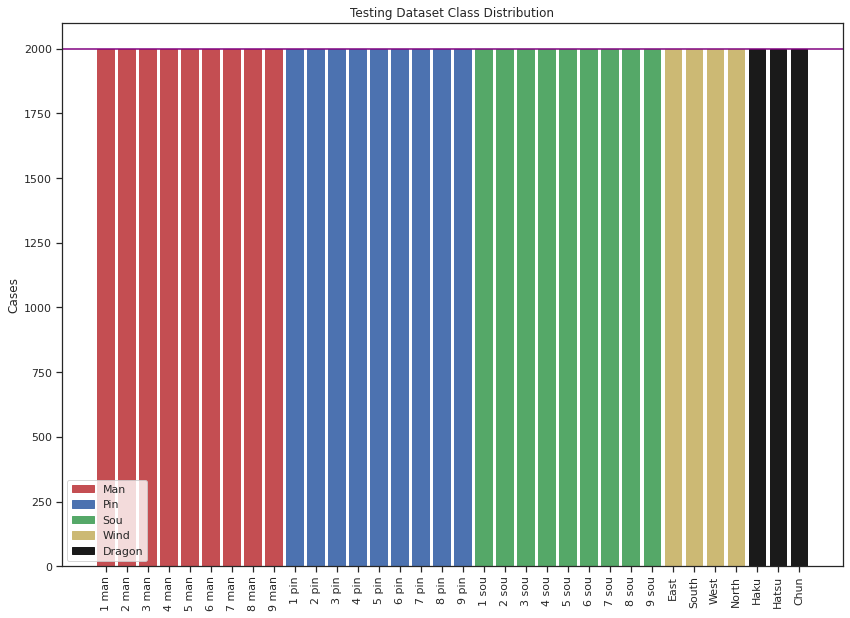

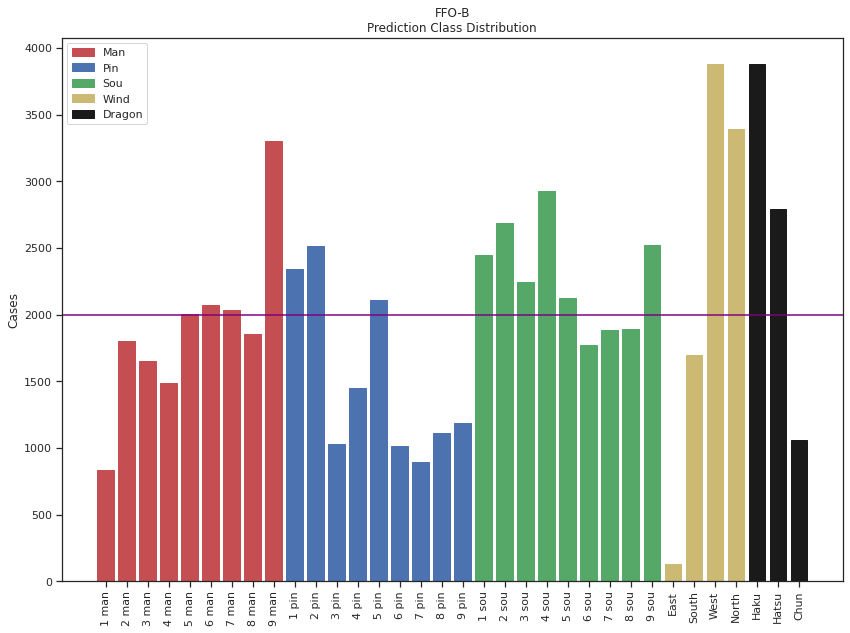

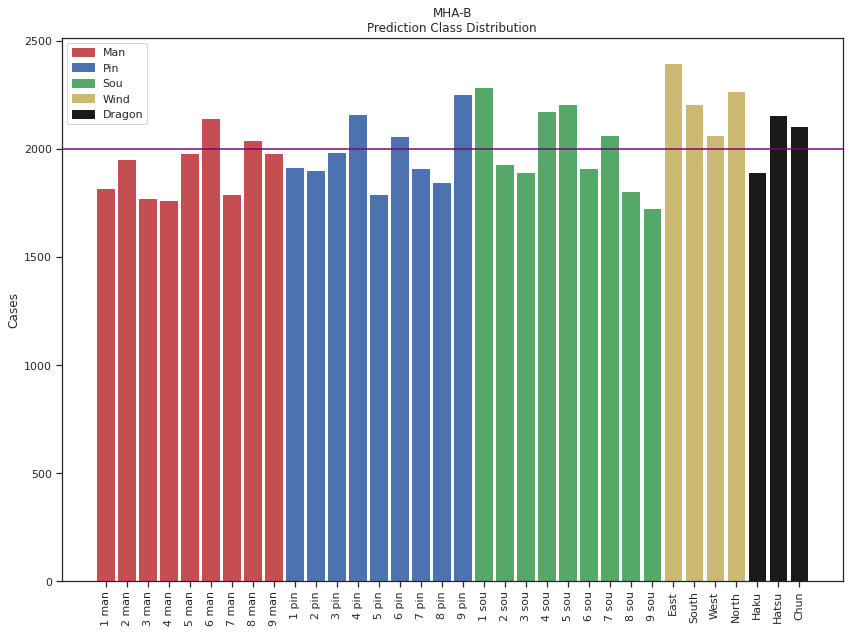

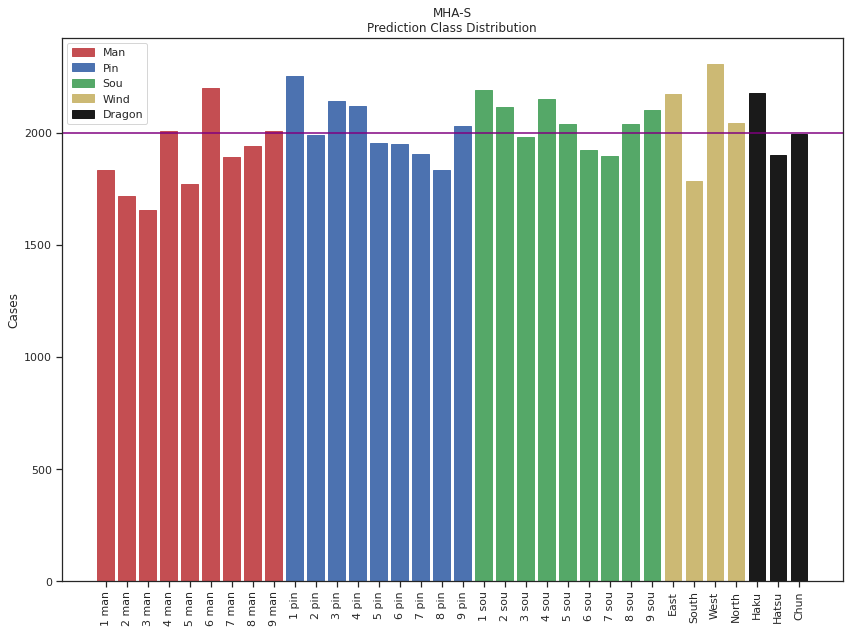

In [69]:
generate_dataset_class_distribution(test_dataset.y_data, "Testing Dataset Class Distribution", horizontal=False)

for model_name in models:
    generate_dataset_class_distribution(all_predictions[model_name], f"{model_name}\nPrediction Class Distribution", horizontal=False)

### Concatenated Distribution

In [91]:
sns.color_palette("hls", 10)[0]

(0.86, 0.3712, 0.33999999999999997)

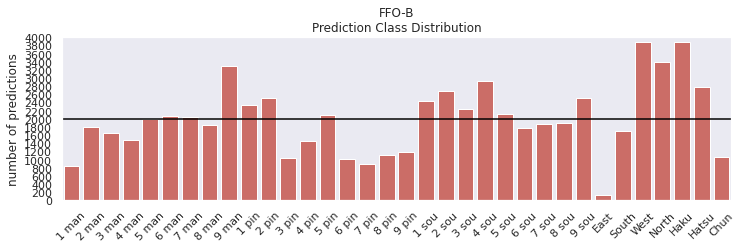

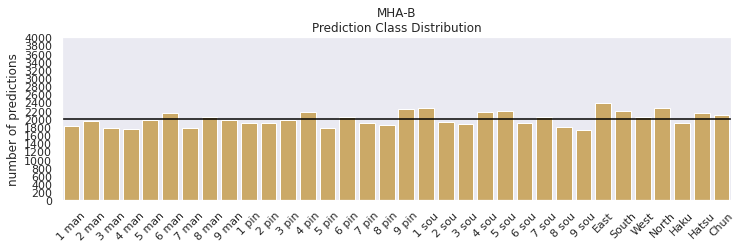

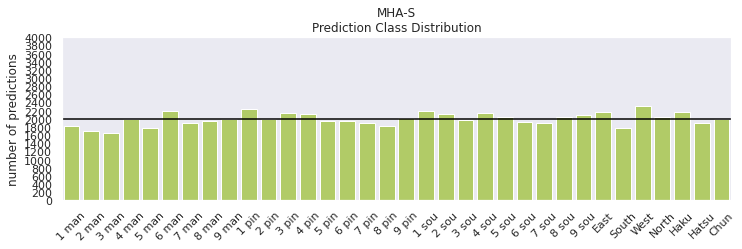

In [123]:
for i, model_name in enumerate(models):
    keys_0, counts_0 = np.unique(test_dataset.y_data, return_counts=True)
    keys_1, counts_1 = np.unique(all_predictions[model_name], return_counts=True)

    fig = plt.figure(figsize=(12, 3))

    df1 = pd.DataFrame({'classes':keys_0, 'cases':counts_0})
    df2 = pd.DataFrame({'classes':keys_1, 'cases':counts_1})

    df1['source'] = "Actual"
    df2['source'] = "Predicted"
    
#     res=pd.concat([df1, df2])
    res=df2

    
    plt.axhline(y=2000, alpha=1, color='black', linestyle='-')  # TEMPORARY

    color = sns.color_palette("hls", 10)[i]
    sns.barplot(x='classes', y='cases', data=res, color=color).set(ylabel='number of predictions', xlabel=None)
    plt.title(f'{model_name}\nPrediction Class Distribution')
    plt.grid(axis='y')
    plt.xticks(range(34), ticks_tiles_oneline, rotation=45)
    plt.yticks(np.arange(0, 4200, 200))
    plt.ylim(0,4000)
    
    plt.savefig(Path('figures') / f'{model_name}_predict_distribution_testing.png', bbox_inches='tight')

    plt.show()

## Confusion Matrix

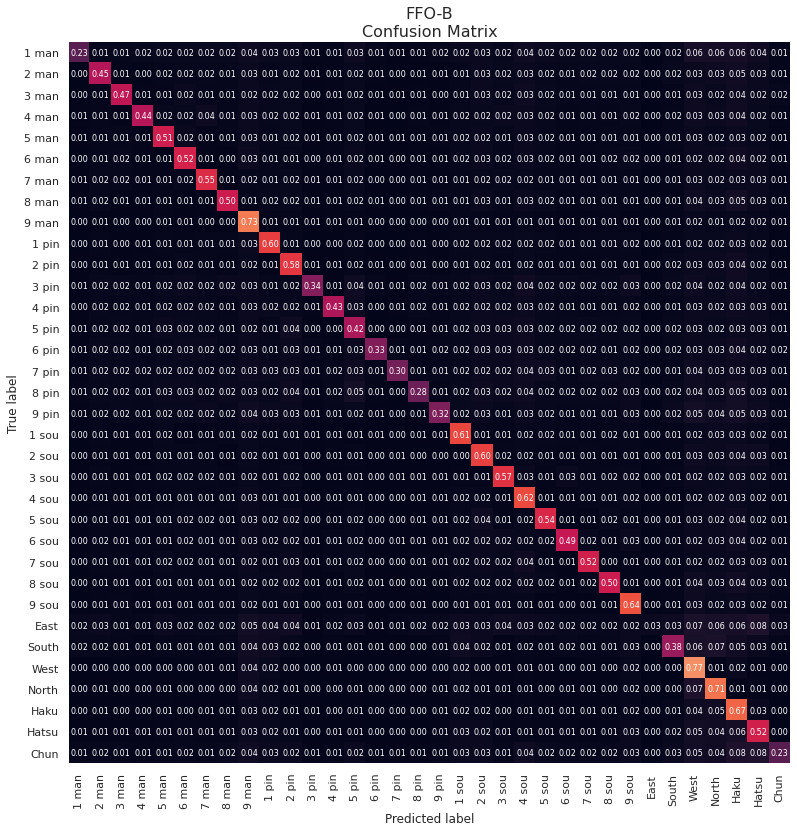

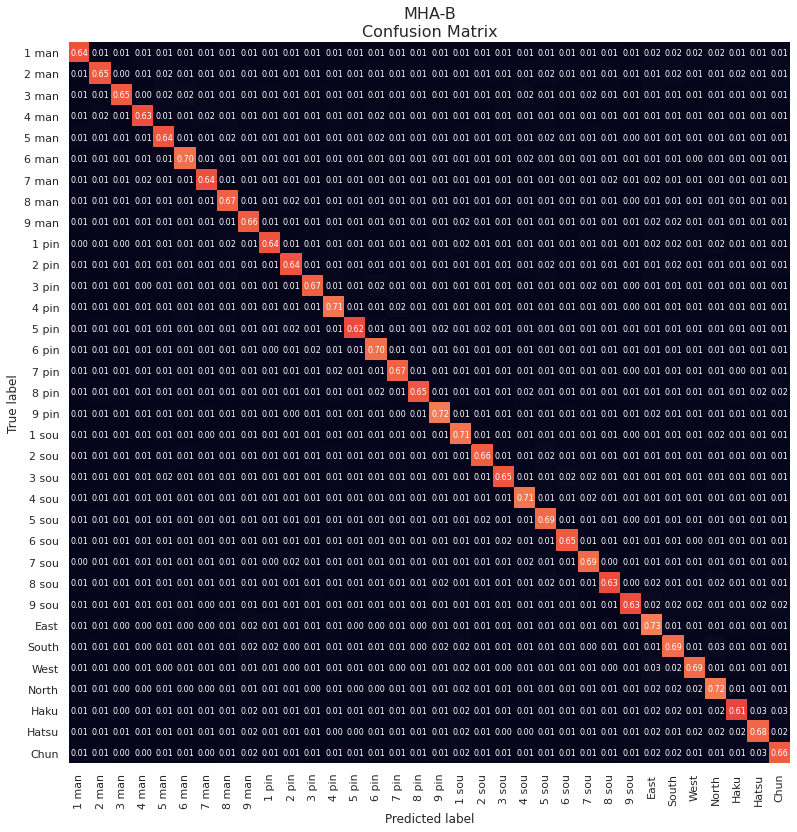

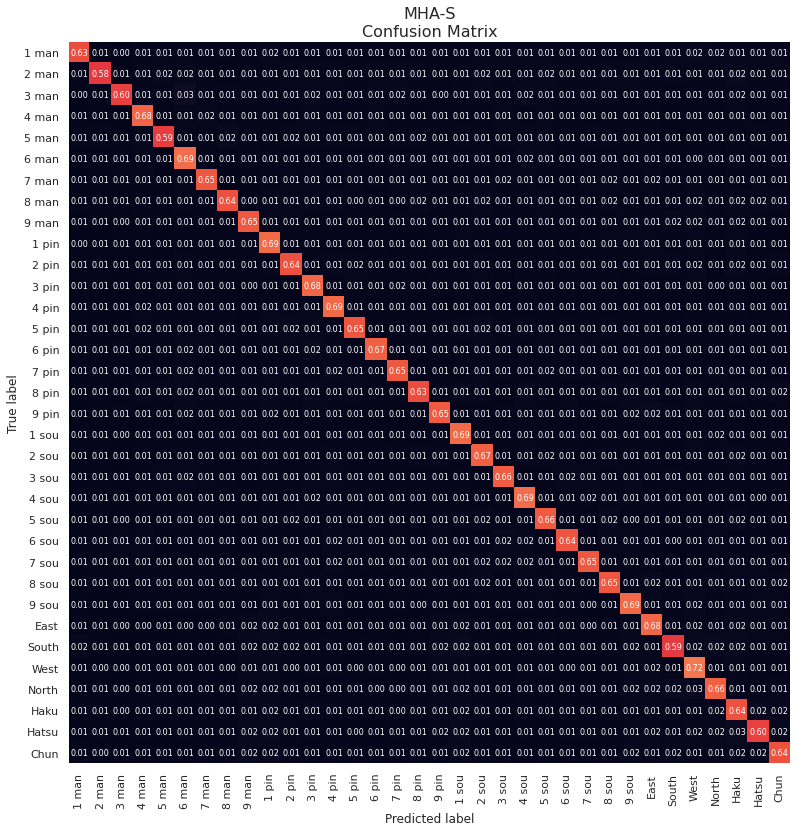

In [144]:
for model_name in models:
    confusion_nparray = sklearn.metrics.confusion_matrix(targets, all_predictions[model_name], normalize='true')
    df_cm = pd.DataFrame(confusion_nparray)
    plt.figure(figsize=(11, 11))
    sns.set(font_scale=1) # for label size
    sns.heatmap(
        df_cm, 
        annot=True, 
        fmt='.2f',  # https://stackoverflow.com/a/65020192
        annot_kws={"size": 8}, 
        square=True, 
        xticklabels=ticks_tiles_oneline, 
        yticklabels=ticks_tiles_oneline,
        vmin=0, vmax=1,
        cbar=False,
#         center=0.5,
#         cbar_kws=dict(shrink=0.5, label='Percentage', )
    )

    plt.tight_layout()

    plt.title(f'{model_name}\nConfusion Matrix', fontsize=16)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig(Path('figures') / f'{model_name}_confusion_matrix.png', bbox_inches='tight')

    plt.show()

# Pretty Print

In [ ]:
import utilities.tiles as tc

def pretty_print_x(x):
    
    def get_wind(value):
        if value == 0:
            return 'EAST'
        elif value == 1:
            return 'SOUTH'
        elif value == 2:
            return 'WEST'
        else:
            return 'NORTH' 
    
    if isinstance(x, torch.Tensor):
        x = [int(n) for n in x.tolist()]
    elif isinstance(x, np.ndarray):
        x = [int(n) for n in x.tolist()]

    round_wind = get_wind(x[0])
    dealer = get_wind(x[1])
    player = get_wind(x[2])

    print(f"Round Wind       = {round_wind}")
    print(f"Dealer           = {dealer}")
    print(f"POV Player       = {player}")
    print()
    print(f"Honba / Riichi Count = {int(x[3])} / {int(x[4])}")
#     print(f"Riichi Count     = {int(x[4])}")
#     print()
    print(f"Wall Tiles left  = {int(x[5])}")

#     print()
#     for i in range(4):
#         print(f"P{i} Score         = {int(x[6 + i]) * 1000}")

#     print()
    print("Score =\t [ {} / {} / {} / {} ]".format(*(int(x[6 + i]) * 1000 for i in range(4))))

    print("Riichi Status =\t [{}-{}-{}-{}]".format(*(x[10 + i] for i in range(4))))
#     for i in range(4):
#         print(f"P{i} Riichi Status = {bool(x[10 + i])}")

    # TILES
    to_tiles = lambda l: tc.TilesConverter.to_one_line_string(tc.TilesConverter.to_136_array(l))

    print()
    print(f"Dora Indicators = {to_tiles(x[34:68])}")
    print()
    print(f"POV Hand        = {to_tiles(x[68:102])}")
    print()
    for i in range(4):
        print(f"P{i} Melds        = {to_tiles(x[102 + (34 * i):136 + (34 * i)])}")

    print()
    for i in range(4):
        print(f"P{i} Pools        = {to_tiles(x[238 + (34 * i):272 + (34 * i)])}")

# Index and Attention Heatmap

In [169]:
def generate_input_heatmap(input_array: np.array, title=None, cbar=True, color_scheme='white', grid_color='black', output_path=None, show_fig=True):
    
    annot_fontsize = 14
    tick_fontsize = 14

    
    assert color_scheme in ['white', 'attention', 'plain']
        
    assert (input_array.shape[0] == 11 or input_array.shape[0] == 15) and input_array.shape[1] == 34
    is_11x34_data = input_array.shape[0] == 11
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharex='col', gridspec_kw={'width_ratios':[120, 2]})  # ax1 = heatmap, ax2 = colormap
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(18, 9), gridspec_kw={"height_ratios":[120, 4]})  # ax1 = heatmap, ax2 = colormap


    twin1 = ax1.twiny()
    
    if is_11x34_data:
        yticklabels=[
            'Metadata',
            'Dora\nindicators',
            'POV hand',
            'P0 melds',
            'P1 melds',
            'P2 melds',
            'P3 melds',
            'P0 pool',
            'P1 pool',
            'P2 pool',
            'P3 pool',
        ]
    else:
        yticklabels=[
            'Metadata',
            'Dora indicators',
            'POV hand',
            'P0 melds',
            'P1 melds',
            'P2 melds',
            'P3 melds',
            'P0 pool',
            'P1 pool',
            'P2 pool',
            'P3 pool',
            'P0 discards',
            'P1 discards',
            'P2 discards',
            'P3 discards',
        ]
    
    # TODO: Mask for interesting effects?
#     mask = np.zeros((11, 34))
#     mask[0, 5:10] = 1
    
    # Common Params
    heatmap_params = dict(
        ax=ax1,
        annot=True,
        fmt='g',
#         mask=mask,
        square=False,
        xticklabels=ticks_tiles_oneline,
        yticklabels=yticklabels,     
        annot_kws={"fontsize": annot_fontsize},
        robust=True,        
        cbar=True,  # cbar param is always true, but we instead turn it invisible later if cbar is disabled
        cbar_ax=ax2,
        cbar_kws=dict(
#             shrink=0.3, 
            label='Attention value',
#             use_gridspec=False,
            orientation="horizontal"
        )
    )
    
    # Extension of Params
    if color_scheme == 'attention':
        mask = input_array != 0
        heatmap_params.update(dict(
#             mask=mask,
#             cmap="coolwarm",
            cmap="icefire",
            center=0,
            vmin=-30,
            vmax=30,
#             norm=matplotlib.colors.BoundaryNorm([-128, 0, 0, 128], 3),
#             cmap=sns.color_palette(["#ffb703",
#                                     "#FFFFFF", 
#                                     "#58b4d1",]),

        ))
    elif color_scheme == 'plain':
#         mask = np.zeros((11, 34))
#         mask[0, 14:34] = 1
        heatmap_params.update(dict(
#             mask=mask,
            norm=matplotlib.colors.BoundaryNorm([-128, 0, 1, 2, 3, 4, 128], 7),
            cmap=sns.color_palette(["#000000",
                                    "#FFFFFF", 
                                    "#EA2027", 
                                    "#EE5A24", 
                                    "#F79F1F", 
                                    "#FFC312", ])))
    else:
        
        heatmap_params.update(dict(cmap=sns.color_palette(["#FFFFFF"])))  # All white
        
        # Show Meta Data vs Tile Data (UNCOMMENT TO USE THIS!)
#         heatmap_params.update(dict(
#         norm=matplotlib.colors.BoundaryNorm([1, 34, 45], 3),
#         cmap=sns.color_palette([
#             "#e74c3c", # Metadata Color
#             "#FFFFFF", # Ignore
#             "#2980b9", # Tile Data Color
#         ])))
        

        
    if grid_color == None:
        linewidths = 0
    else:
        heatmap_params.update(dict(linewidths=1, linecolor=grid_color))
    
    # Heatmap Creation
    ax1 = sns.heatmap(pd.DataFrame(input_array), **heatmap_params)

#     twin1.set_xlabel("Metadata Labels")
    twin1.set_xlim(ax1.get_xlim())
    twin1.set_xticks(ax1.get_xticks())
    metadata_labels = [
        'Round wind',
        'Dealer',
        'POV player',
        '# honba sticks',
        '# riichi sticks',
        '# wall tiles',
        'P0 score',
        'P1 score',
        'P2 score',
        'P3 score',
        'P0 riichi status',
        'P1 riichi status',
        'P2 riichi status',
        'P3 riichi status',
    ] + ['Padding' for _ in range(20)]
    twin1.set_xticklabels(labels=metadata_labels, rotation='vertical')
    twin1.grid(False)  # Remove weird white vertical lines that sometimes appears

    ax1.hlines(range(1, 2), -0.5, 34.5, linewidth=7, color=grid_color)  # Metadata separator line

    # Ticks Configuration
    ax1.tick_params(left=False, bottom=False, top=False, labelsize=tick_fontsize)
    ax1.xaxis.set_tick_params(rotation=90)

    twin1.tick_params(top=False, labelsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    
    ax2.xaxis.label.set_size(15)  # Colorbar Label Size
    ax2.xaxis.set_tick_params(labelsize=12)
    
    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    
    if title:
        plt.title(title)
    
    if not cbar:
        ax2.set_visible(False)
    
    if output_path is not None:
        plt.savefig(output_path, bbox_inches='tight')
    
    if show_fig:
        plt.show()

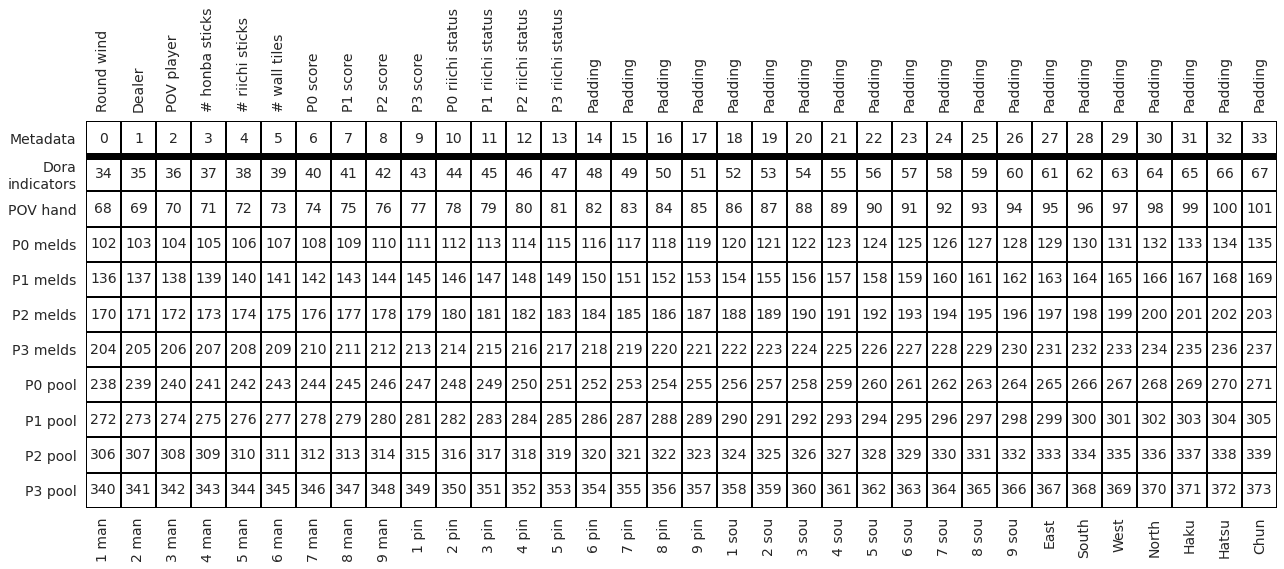

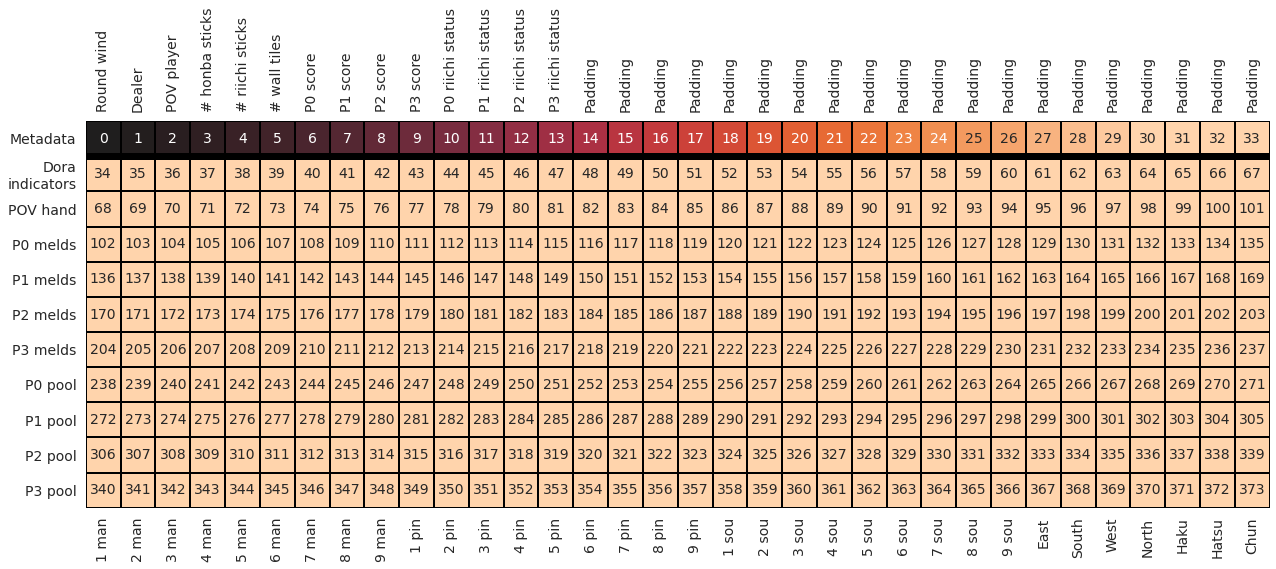

NameError: name 'pretty_print_x' is not defined

In [170]:
# Index Heatmap
generate_input_heatmap(np.arange(0, 374).reshape(11, 34), cbar=False, color_scheme='white', title=None)
generate_input_heatmap(np.arange(0, 374).reshape(11, 34), cbar=False, color_scheme='attention', title=None)


# Validation Heatmaps
model.eval()

n_inputs = 5
x = validation_dataset[100:105]['X'].to(DEVICE)  # GET CORRECT DATA
x = x.reshape(1, x.shape[0], 374)
attn_output, _ = model.mha1(query=x, key=x, value=x, need_weights=None)
attn_output = attn_output.reshape(n_inputs, 374)

for i, attention_values in enumerate(attn_output):
    
    pretty_print_x(x[0, i])

    
    x_arr = x[0, i].cpu().detach().numpy().reshape(11, 34)
    generate_input_heatmap(x_arr, cbar=False, color_scheme='plain')

    
    attention_result = attention_values.reshape(11, 34).cpu().detach().numpy()
    attention_result = np.around(attention_result, decimals=0)
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color=None)
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color='white')
    generate_input_heatmap(attention_result, color_scheme='attention', grid_color='black')

    break # TODO: REMOVE!

# Find Specific game

In [194]:
def find_specific_game_array(game_url: str):
    """
    Find game array if given game ID exists in discard dataset.
    Returns X (np.array) and y (int)
    """
    
    params = dict([el.split('=') for el in game_url.split('?')[1].split('&')])

    params['tj'] = int(params['tj'])
    params['ts'] = int(params['ts'])
    params['tw'] = int(params['tw'])
#     print(params)

    log_path = Path.home() / 'MasterThesis' / 'data' / 'discard_datasets' / params['log'][:4] / (params['log'] + '.npz')

    assert log_path.exists(), "Log does not exist!"  # Check if file exists in our dataset

    arr = scipy.sparse.load_npz(log_path).toarray()
    arr = arr.astype('int16')
    arr[:, 33] += 128 - 1  # Remove offset
    arr = arr[arr[:,  2] == params['tw']]  # Filter POV (Unnecessary, but makes sure it is correct)
    arr = arr[arr[:, 32] == params['ts']]  # Filter Round
    print(arr[:, 33])
    arr = arr[arr[:, 33] == params['tj']]  # Filter Step

    assert arr.shape[0] == 1, f"Expected 1 row, got: '{arr.shape}'"

    arr[:, 32] = -128  # Reset to padding value
    arr[:, 33] = -128  # Reset to padding value

    return arr[0][0:374], int(arr[0][-1])

## 34-array beautiful

In [220]:
import matplotlib.transforms as mtrans


def draw_sexy_predictions(output, sort_predictions=True, title=None, output_path=None):
    """
    :param: output: Normalized 34 array output (softmaxed)
    """
    
    assert output.shape[0] == 34
        
    if sort_predictions:
        sorted_output_indices = np.argsort(output)[::-1]
    else:
        sorted_output_indices = range(34)

    data = output[sorted_output_indices]

#         data = data[0:10]
#         sorted_output_indices = sorted_output_indices[0:10]

    np.set_printoptions(precision=3)

    fig = plt.figure(figsize=(18.5, 0.8))
    ax = fig.gca()
    plt.bar(np.arange(len(data)), data, width=0.2, linewidth=1, edgecolor='black')

    plt.grid(axis = 'y')

    xticks = [ticks_tiles_oneline[i] for i in sorted_output_indices]
    plt.xticks(range(len(data)), xticks[0:len(data)], rotation=45, position=(0, -0.7), fontsize=13)
    
    plt.yticks(np.arange(0, 1.25, 0.25))

    plt.xlim(-0.5, 33.5)
    plt.ylim(0, 1)

    fig.patch.set_visible(False)
    
    # Move the tick labels some pixels to the right
    trans = mtrans.Affine2D().translate(-8, 0)
    for t in ax.get_xticklabels():
        t.set_transform(t.get_transform()+trans)
    
    if title is not None:
        plt.title(title, fontsize=15)

    plt.savefig('out/34bar.svg', bbox_inches='tight', transparent=False)
    plt.close()

    x = 64.5
    y = 30 if title is None else 43
    

    list_of_svgs = [
        sc.Panel(sc.SVG("out/34bar.svg").scale(1)),
    ]

    for i in sorted_output_indices:
        list_of_svgs.append(sc.Panel(sc.SVG(get_tile_svg(int(i))).scale(0.11).move(x, y)))
        x += 30.35

    sc.Figure("28.42cm", "4cm", *list_of_svgs).save(output_path)

    display(SVG(output_path))

In [221]:
def draw_some_sexy_predictions(output, tiles=5, color=None, title=None, output_path=None):
    """
    :param: output: Normalized 34 array output (softmaxed)
    """
    
    assert output.shape[0] == 34
        
    sorted_output_indices = np.argsort(output)[::-1]  # Always sort if only some tiles are drawn!

    data = output[sorted_output_indices]

    data = data[0:tiles]
    sorted_output_indices = sorted_output_indices[0:tiles]

    np.set_printoptions(precision=3)

    fig = plt.figure(figsize=(5, 0.8))
    ax = fig.gca()
    plt.bar(np.arange(len(data)), data, width=0.1, linewidth=1, edgecolor='black', color=color)

    plt.grid(axis = 'y')
    
    xticks = [ticks_tiles_oneline[i] for i in sorted_output_indices]
    placements = ['1st', '2nd', '3rd', '4th', '5th']
    
#     xticks = [placements[i] + f"\n\n\n\n\n{xticks[i]}" for i in range(tiles)]
    x=-0.32
    y=-2.1
    for text in xticks:
        plt.text(x, y, text)
        x += 1

    plt.xticks(range(tiles), placements[0:tiles], rotation=0, position=(0, 0), fontsize=15)
    
    plt.yticks(np.arange(0, 1.5, 0.5))

    plt.xlim(-0.5, tiles - 1 + 0.5)
    plt.ylim(0, 1)

    fig.patch.set_visible(False)
    
    # Move the tick labels some pixels to the right
#     trans = mtrans.Affine2D().translate(-8, 0)
#     for t in ax.get_xticklabels():
#         t.set_transform(t.get_transform()+trans)
    
    if title is not None:
        plt.title(title, fontsize=15)
        
#     plt.show()
    plt.savefig('out/34bar.svg', bbox_inches='tight', transparent=True)
    plt.close()

    x = 78
    y = 30 if title is None else 35
    

    list_of_svgs = [
        sc.Panel(sc.SVG("out/34bar.svg").scale(1)),
    ]

    for i in sorted_output_indices:
        list_of_svgs.append(sc.Panel(sc.SVG(get_tile_svg(int(i))).scale(0.20).move(x, y)))
        x += 56.3

    sc.Figure("9cm", "5cm", *list_of_svgs).save(output_path)

    display(SVG(output_path))

In [222]:
def draw_stacked_sexy_predictions(outputs, model_names, sort_predictions=True, title=None, output_path=None):
    """
    :param: outputs: Normalized 34 array output (softmaxed)
    """
    np.set_printoptions(precision=3)
    
#     fig = plt.figure(figsize=(18.5, 0.8))
    fig, ax = plt.subplots(figsize=(18.5, 2.3))
    width = 0.2

#     ax = fig.gca()

#     if sort_predictions:
#         sorted_output_indices = np.argsort(outputs)[::-1]
#     else:
#         sorted_output_indices = range(34)
    
    for i, output in enumerate(outputs):
        
        
    

#     data = output[sorted_output_indices]

#         data = data[0:10]
#         sorted_output_indices = sorted_output_indices[0:10]    
    
        plt.bar(np.arange(len(output)) + (width * i) - width, 
                output, 
                width=width, 
                align='center', 
                linewidth=1, 
                edgecolor='black')

    plt.grid(axis = 'y')
    
    ax.legend(model_names)

    xticks = [ticks_tiles_oneline[i] for i in sorted_output_indices]
    plt.xticks(range(34), xticks[0:34], rotation=45, position=(0, -0.25), fontsize=13)
    
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    plt.ylabel('Probability', fontsize=13)

    plt.xlim(-0.5, 33.5)
    plt.ylim(0, 1)

    fig.patch.set_visible(False)
    
    # Move the tick labels some pixels to the right
    trans = mtrans.Affine2D().translate(-8, 0)
    for t in ax.get_xticklabels():
        t.set_transform(t.get_transform()+trans)
    
    if title is not None:
        plt.title(title, fontsize=16)

    plt.savefig('out/34bar.svg', bbox_inches='tight', transparent=False)
    plt.close()

    x = 74
#     x = 58

    y = 95.5 if title is None else 125
    

    list_of_svgs = [
        sc.Panel(sc.SVG("out/34bar.svg").scale(1)),
    ]

    for i in sorted_output_indices:
        list_of_svgs.append(sc.Panel(sc.SVG(get_tile_svg(int(i))).scale(0.11).move(x, y)))
        x += 30.35

    sc.Figure("28.8cm", "6.1cm", *list_of_svgs).save(output_path)

    display(SVG(output_path))

In [223]:
def print_sexy_target(target, output_path=None):
    """
    :param: output: Normalized 34 array output (softmaxed)
    """
    
    print(target)
    
    fig = plt.figure(figsize=(1, 0.8))
    ax = fig.gca()
    
    plt.text(x=0.3, 
             y=0.8, 
             s="Target",
             fontsize=16
            )

    plt.text(x=0.3, 
             y=-2.1, 
             s=ticks_tiles_oneline[int(target)],
             fontsize=15
            )

    fig.patch.set_visible(False)
    ax.axis('off')

#     plt.title("Target", fontsize=15)
        
#     plt.show()
    plt.savefig('out/34bar.svg', bbox_inches='tight', transparent=True)
    plt.close()

    x = 83
    y = -90

    list_of_svgs = [
        sc.Panel(sc.SVG("out/34bar.svg").scale(1)),
    ]

#     for i in sorted_output_indices:
    list_of_svgs.append(sc.Panel(sc.SVG(get_tile_svg(int(target))).scale(0.4).move(x, y)))
#         x += 56.3

    sc.Figure("2.5cm", "5cm", *list_of_svgs).save(output_path)

    display(SVG(output_path))

[  5  13  21  29  37  45  53  61  69  78  86  94 102 110 119 127 135]


log=2018052710gm-00a9-0000-863640fd&tw=2&ts=0&tj=127
https://tenhou.net/5/?log=2018052710gm-00a9-0000-863640fd&tw=2&ts=0&tj=127


HAND: 14 tiles - Efficiency Calculator: https://tenhou.net/2/?q=13455m22335p2567s


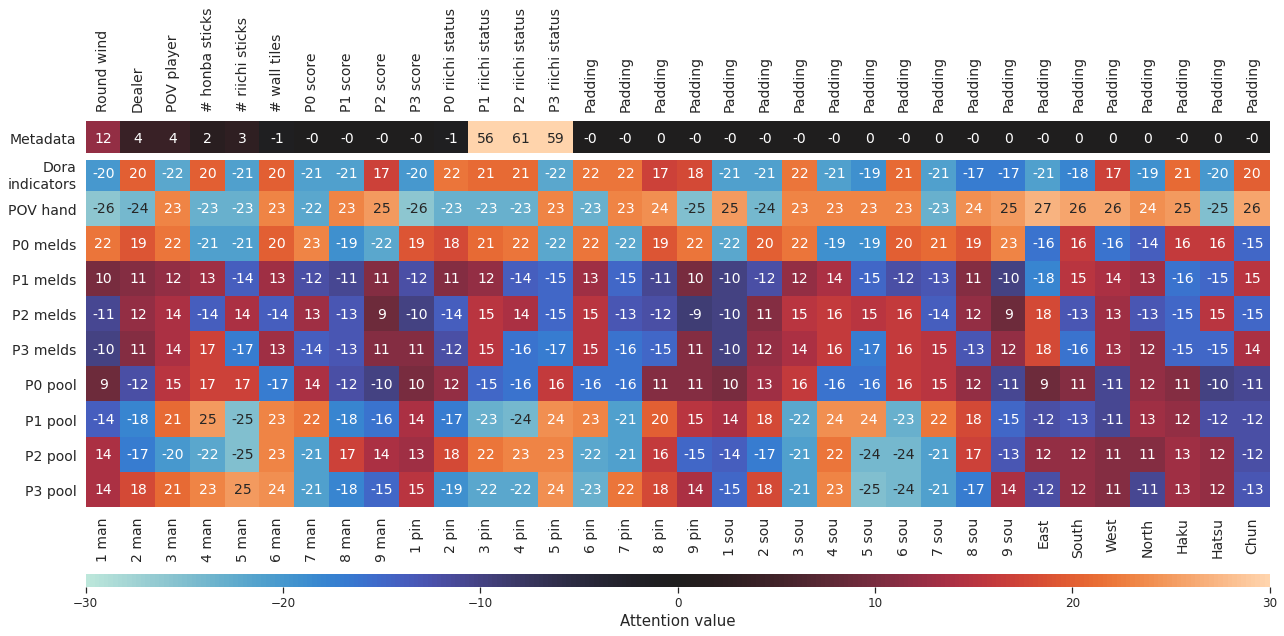

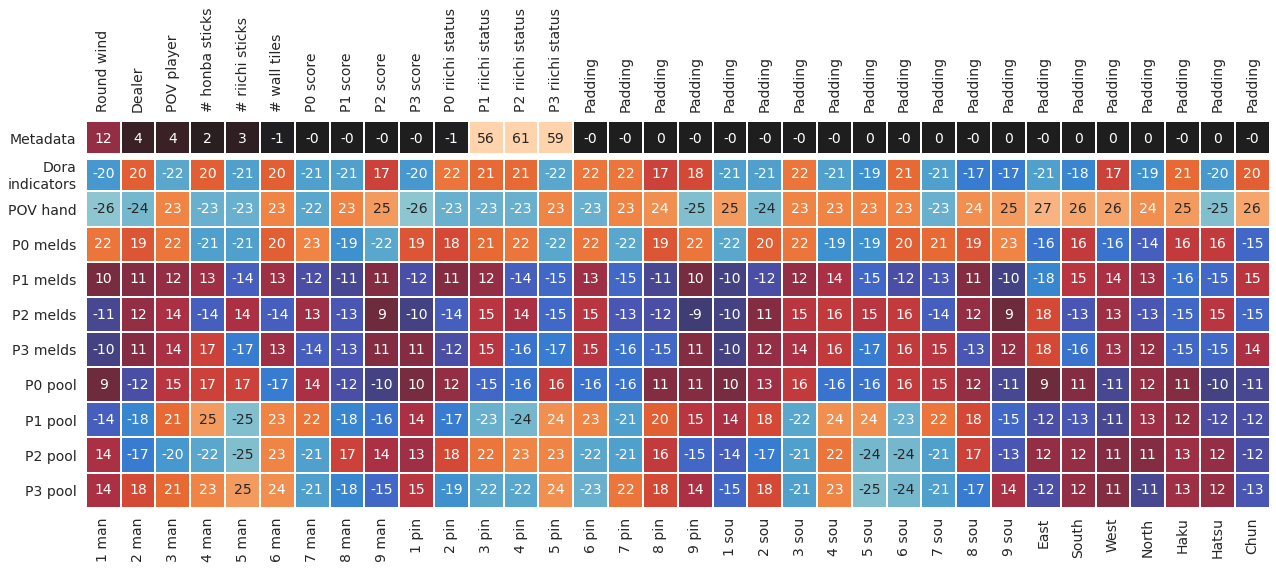

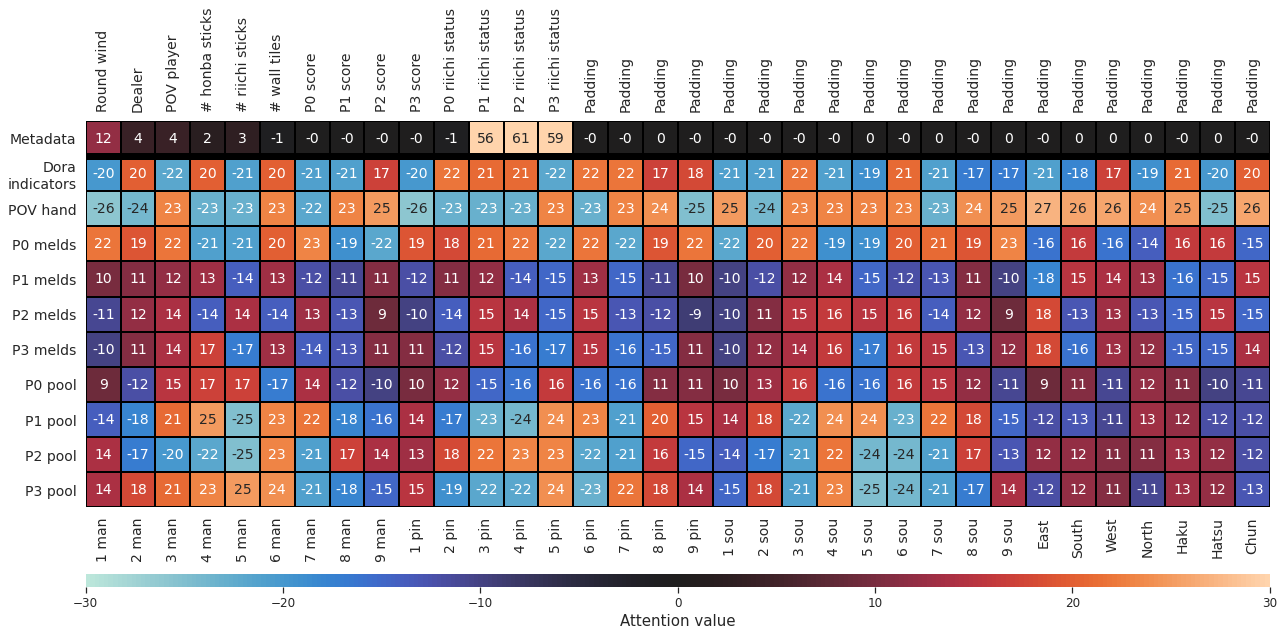

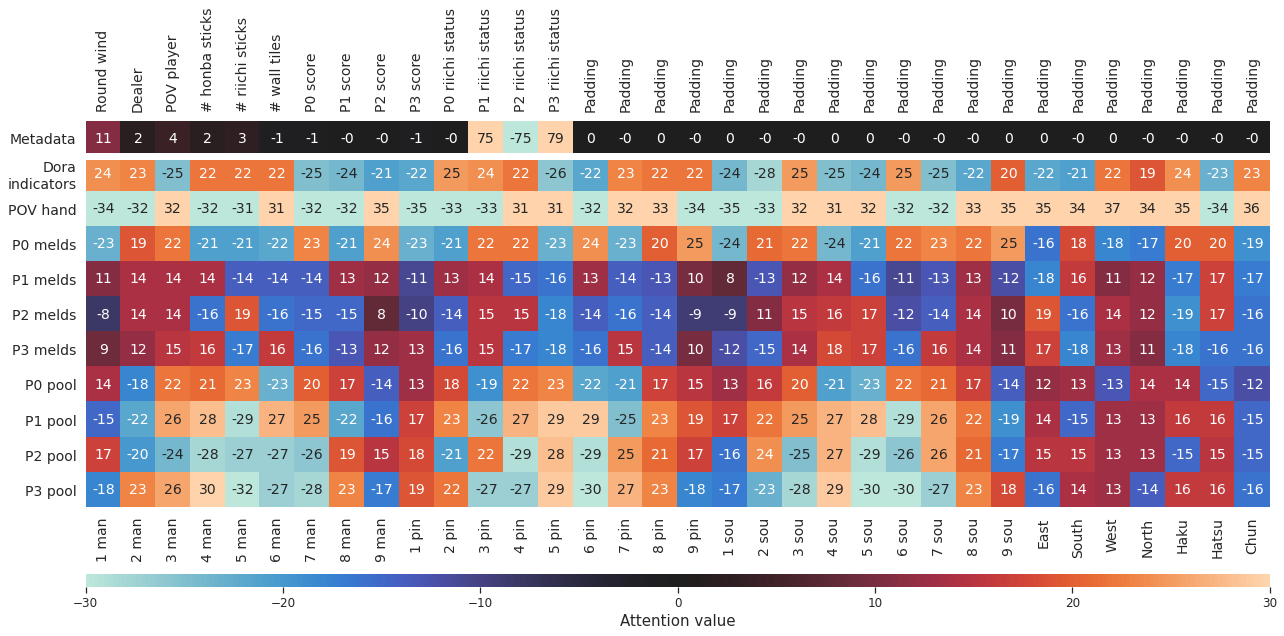

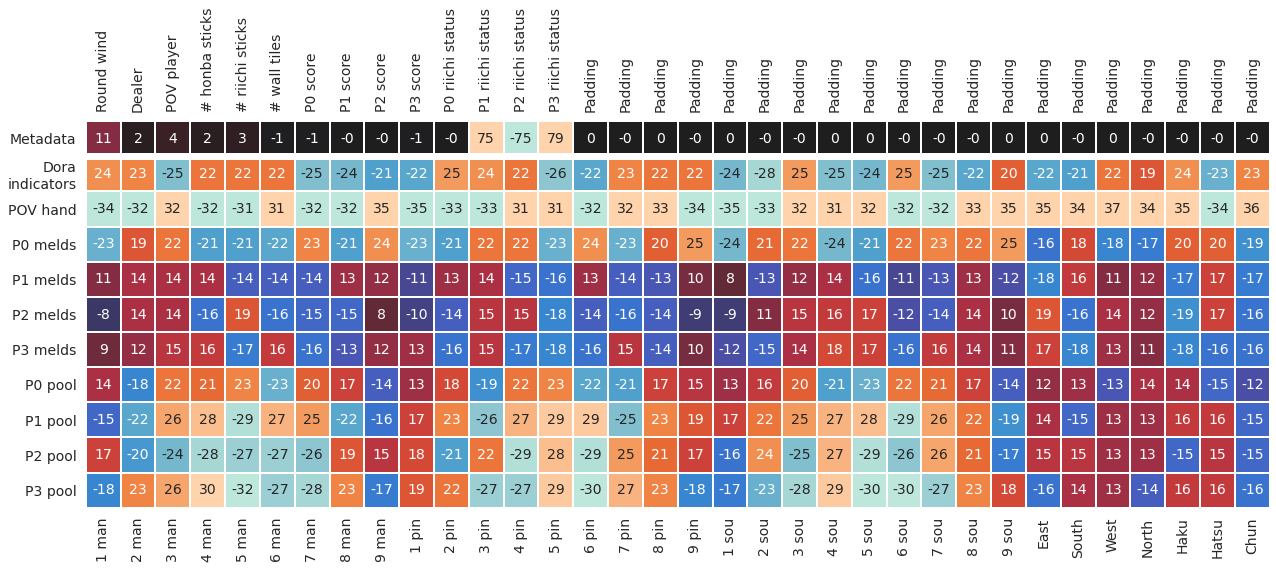

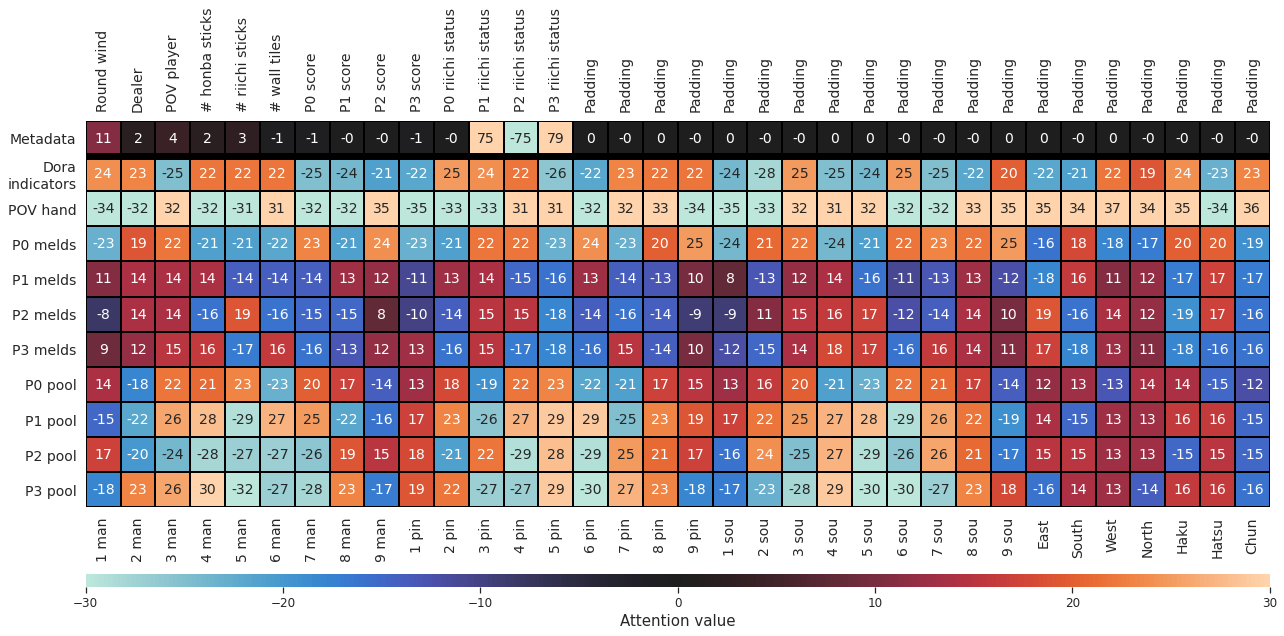

0


NameError: name 'sorted_output_indices' is not defined

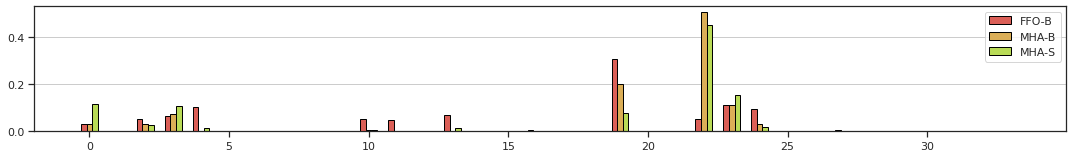

In [224]:
import svgutils.compose as sc
from IPython.core.display import display, HTML
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

sns.set_style("ticks")
# sns.set_palette('bright')
sns.set_palette(sns.color_palette("hls", 10))

urls = [
#     "https://tenhou.net/5/?log=2018052710gm-00a9-0000-863640fd&tw=0&ts=7&tj=93",
    "https://tenhou.net/5/?log=2018052710gm-00a9-0000-863640fd&tw=2&ts=0&tj=127",
#     "https://tenhou.net/5/?log=2018052710gm-00a9-0000-863640fd&tw=1&ts=1&tj=27",
#     "https://tenhou.net/5/?log=2018052710gm-00a9-0000-863640fd&tw=2&ts=1&tj=29",
]

# attention_figure_output = (Path('figures') / 'attention_examples')
# attention_figure_output.mkdir(exist_ok=True)


for url in urls:
    X, y = find_specific_game_array(url)
        
    display(HTML(f"<h2>{url}</h2>"))
    file_name = url.split('?')[1]
    print(file_name)
    print(url)
    
    prediction_values_path = (Path('figures') / file_name)
    prediction_values_path.mkdir(exist_ok=True)
    
    (prediction_values_path / 'source.txt').write_text(url + f"\nTiles Left = {X[5]}")    

    
    picture_print_x(X)
    
    
    # Paint Attention Matrix
    for model_name, model_object in models.items():
        
#         print(model_name)
        model_object.eval()
        
        if model_name[0:3] == 'MHA':
            x = torch.FloatTensor(X.reshape(1, 1, 374)).to(DEVICE)
            attn_output, _ = model_object.mha1(query=x, key=x, value=x, need_weights=None)
            attn_output = attn_output.reshape(11, 34).cpu().detach().numpy()
            attn_output = np.around(attn_output, decimals=0)
            
            # Summary Print
#             print("Zeros: ", (attn_output == 0).sum())
#             print(">0: ", (attn_output > 0).sum())
#             print("<0: ", (attn_output < 0).sum())
            
            # Attention Matrix Flavours
            attention_output = prediction_values_path / f'attention-{model_name}'
            generate_input_heatmap(attn_output, color_scheme='attention', grid_color=None,    cbar=True,  show_fig=True, output_path=prediction_values_path / f'attention-{model_name}-nogrid')
            generate_input_heatmap(attn_output, color_scheme='attention', grid_color='white', cbar=False, show_fig=True, output_path=prediction_values_path / f'attention-{model_name}-whitegrid')
            generate_input_heatmap(attn_output, color_scheme='attention', grid_color='black', cbar=True,  show_fig=True, output_path=prediction_values_path / f'attention-{model_name}-blackgrid')
    
    print_sexy_target(y, 
                      output_path=prediction_values_path / 'target.svg')
    
    outputs = []
    for i, (model_name, model_object) in enumerate(models.items()):
        
        input_x = torch.FloatTensor(X).reshape(1, -1).to(DEVICE)
        output = torch.softmax(model_object(input_x)[0], dim=0)
        output_arr = output.detach().cpu().numpy()
        outputs.append(output_arr)
        
        draw_sexy_predictions(output_arr, 
                              sort_predictions=False, 
                              title=f"Prediction Probabilities",
                              output_path=prediction_values_path / 'composed.svg'
                             )  # Single Plot
        
        draw_some_sexy_predictions(output_arr, 
                                   color=sns.color_palette("hls", 10)[i], 
                                   title=f"Sorted Probabilities ({model_name})",
                                   output_path=prediction_values_path / (model_name + '.svg')
                                  )


#     print("Target:")
#     display(HTML(f"<img src='{get_tile_svg(y)}' width=100>"))

#     display(SVG(get_tile_svg(y), witdh=0.5))
        
    draw_stacked_sexy_predictions(outputs, 
                                   models.keys(), 
                                   title="Prediction Probabilities",
                                   output_path=prediction_values_path / 'stacked.svg'
                                  )
    
    generate_input_heatmap(X.reshape((11, 34)), cbar=False, color_scheme='plain', output_path=prediction_values_path / "data_structure.png")


# Pretty Print Predictions

In [209]:
from pathlib import Path
from time import sleep

import numpy as np
import scipy.sparse

from IPython.display import SVG, HTML, Image

import utilities.tiles as tc
from utilities.shanten import Shanten

import utilities.mahjong_drawer.mahjong_drawer.mahjong_drawer_module as drawer


def get_mahjong_string(array: np.array):
    return tc.TilesConverter.to_one_line_string(tc.TilesConverter.to_136_array(array.tolist())).replace('z', 'h')

# Utility Classes
md = drawer.MahjongDrawer('utilities/mahjong_drawer/mahjong_drawer/svg')
shanten = Shanten()

def get_tile_svg(class_number: int):
    """ Faster fetch for single tile. """
    svg_folder = "utilities/mahjong_drawer/mahjong_drawer/svg/"
    if class_number < 9:
        return svg_folder + "tile_m{}!.svg".format(class_number + 1)
    elif 9 <= class_number < 18:
        return svg_folder + "tile_p{}!.svg".format(class_number - 9 + 1)
    elif 18 <= class_number < 27:
        return svg_folder + "tile_s{}!.svg".format(class_number - 18 + 1)
    else:
        return svg_folder + "tile_h{}!.svg".format(class_number - 27 + 1)

In [206]:
def get_winds_relative_to_dealer(dealer, pov):
    
    winds = [
        ['EAST', 'SOUTH', 'WEST', 'NORTH'],
        ['NORTH', 'EAST', 'SOUTH', 'WEST'],
        ['WEST', 'NORTH', 'EAST', 'SOUTH'],
        ['SOUTH', 'WEST', 'NORTH', 'EAST']
    ]
    
    relative_to_dealer = winds[dealer]
    
    for _ in range(pov):
        relative_to_dealer.append(relative_to_dealer.pop(0))
    
    return relative_to_dealer
    
def get_player_numbers(pov):
    if pov == 0:
        return [0, 1, 2, 3]
    elif pov == 1:
        return [1, 2, 3, 0]
    elif pov == 2:
        return [2, 3, 0, 1]
    else:
        return [3, 0, 1, 2]


def picture_print_x(x, round_num=None, step_num=None, target=None, predicted=None, game_id=None):
    
    display(HTML(f"""
        <h1>{'EAST' if x[0] == 0 else 'SOUTH'} {x[1]} - ROUND {round_num} - Step {step_num}</h1>
    """))
    
    if game_id and round_num and step_num:
        print(f"https://tenhou.net/5/?log={game_id}&tw={x[2]}&ts={round_num}&tj={step_num}")
#     print(f"Honba-Riichi Count: {x[3]}/{x[4]}")
#     print(f"Wall Tiles left: {x[5]}")

    # Meld / Discard creation
    m_string = get_mahjong_string(x[34:68])  # Dora Indicators
    n_backs = 5 - sum(c.isdigit() for c in m_string)
    md.add_hand('b' + m_string + ('b' * n_backs), 'out/dora.svg')
    for i in range(4):
        md.create_discard_pile(get_mahjong_string(x[102 + (34 * i):136 + (34 * i)]), f'out/meld_{i}.svg')
        md.create_discard_pile(get_mahjong_string(x[238 + (34 * i):272 + (34 * i)]), f'out/pool_{i}.svg')
        
    # POV Hand Management
    pov_hand = x[68:102]
    n_tiles = sum(pov_hand)
    m_string_hand = get_mahjong_string(pov_hand).replace('z', 'h')
    m_string_hand = m_string_hand + (' ' * (14 - n_tiles))  # TODO: ADD AFTER KERNEL RESET
    md.add_hand(m_string_hand, 'out/hand.svg')
    
    target_shanten = 69
    if target is not None:
#         temp_34 = np.zeros(34, dtype=int)
#         temp_34[target] = 1
#         md.add_hand(get_mahjong_string(temp_34), f'out/target.svg')
        
        # shanten calculation
        next_hand = pov_hand.tolist()
        next_hand[target] -= 1
        target_shanten = shanten.calculate_shanten(next_hand)


    predicted_shantens = []
    if predicted is not None:
        for i, p in enumerate(predicted):
#             temp_34 = np.zeros(34, dtype=int)
#             temp_34[p] = 1
#             md.add_hand(get_mahjong_string(temp_34), f'out/prediction_{i}.svg')
#             sleep(0.25)
            
            # shanten calculation
            next_hand = pov_hand.tolist()
            next_hand[p] -= 1
            predicted_shantens.append(shanten.calculate_shanten(next_hand))
            
#     assert len(predicted_shantens) == len(predicted)
    
#     sleep(0.2)
#     print(f"HAND: {n_tiles} tiles - Efficiency Calculator: https://tenhou.net/2/?q={m_string_hand.replace('h', 'z')}")
#     display(Image(url='out/hand.svg', width=500))
#     print(f"Hand is {shanten.calculate_shanten(pov_hand.tolist())}-shanten")  # Shanten for hand is pretty confusing!
       
    
    relative_players = get_player_numbers(x[2])
    relative_winds = get_winds_relative_to_dealer(x[1], x[2])
    
    # Player HTML
    p0_b = f'<small style="color:blue">P{relative_players[0]}</small>'
    p1_b = f'<small style="color:blue">P{relative_players[1]}</small>'
    p2_b = f'<small style="color:blue">P{relative_players[2]}</small>'
    p3_b = f'<small style="color:blue">P{relative_players[3]}</small>'
    
    p0 = f'<small>P{relative_players[0]}</small>'
    p1 = f'<small>P{relative_players[1]}</small>'
    p2 = f'<small>P{relative_players[2]}</small>'
    p3 = f'<small>P{relative_players[3]}</small>'

#     sleep(3.0)
    display(HTML(f"""
        <table>

            <tr style="vertical-align:text-bottom">
                <th style="text-align:center">  <h2                                          >{relative_winds[0]} </h2>  </h1>POV (You)            <br> {p0_b} </th>
                <th style="text-align:center">  <h2 style={"color:red" if x[11] == 1 else ""}>{relative_winds[1]} </h2>  </h1>Player to your Right <br> {p1_b} </th>
                <th style="text-align:center">  <h2 style={"color:red" if x[12] == 1 else ""}>{relative_winds[2]} </h2>  </h1>Player across you    <br> {p2_b} </th>
                <th style="text-align:center">  <h2 style={"color:red" if x[13] == 1 else ""}>{relative_winds[3]} </h2>  </h1>Player to your Left  <br> {p3_b} </th>
                <th style="text-align:center">  <br><br><br>Dora Indicators</th>

            </tr> 
            <!--
            <tr>
                <th style="text-align:center">P0 Score</th>
                <th style="text-align:center">P1 Score</th>
                <th style="text-align:center">P2 Score</th>
                <th style="text-align:center">P3 Score</th>
            </tr> 
            -->
            <tr>
                <td style="text-align:center">~{x[6] * 1000}pts</td>
                <td style="text-align:center">~{x[7] * 1000}pts</td>
                <td style="text-align:center">~{x[8] * 1000}pts</td>
                <td style="text-align:center">~{x[9] * 1000}pts</td>
                <td><img src='out/dora.svg'   width=200></td>
            </tr>
            <!--tr>
                <th style="text-align:center"><h5>{p0} Pool</h5></th>
                <th style="text-align:center"><h5>{p1} Pool</h5></th>
                <th style="text-align:center"><h5>{p2} Pool</h5></th>
                <th style="text-align:center"><h5>{p3} Pool</h5></th>
                <th style="text-align:center">Dora Indicators</th>

            </tr--> 
            <tr>
                <th colspan="4" style="text-align:center"> <h4>Pools</h4> </th>
            </tr>
            <tr>
                <td><img src='out/pool_0.svg' width=200></td>
                <td><img src='out/pool_1.svg' width=200></td>
                <td><img src='out/pool_2.svg' width=200></td>
                <td><img src='out/pool_3.svg' width=200></td>
                <td>Wall Tiles left:<h1>{x[5]}</h1></td>
            </tr>
            <!--tr>
                <th style="text-align:center">{p0} Melds</th>
                <th style="text-align:center">{p1} Melds</th>
                <th style="text-align:center">{p2} Melds</th>
                <th style="text-align:center">{p3} Melds</th>
            </tr--> 
            <tr>
                <th colspan="4" style="text-align:center"> <h4>Melds</h4> </th>
            </tr>
            <tr>
                <td><img src='out/meld_0.svg' width=200></td>
                <td><img src='out/meld_1.svg' width=200></td>
                <td><img src='out/meld_2.svg' width=200></td>
                <td><img src='out/meld_3.svg' width=200></td>
                <td>Honba/Riichi Count:<h1>{x[3]}/{x[4]}</h1></td>
            </tr>
            
            <!--tr>
                <th colspan="4" style="text-align:center"> <h4>POV Hand</h4> </th>
            </tr>
            <tr>
                <td colspan="4">
                    <figure style="text-align:center">
                        <img src="out/hand.svg" width=500>
                        <figcaption style="text-align:center">POOOOOP</figcaption>
                    </figure>
                </td>
            </tr-->
        </table>
    """))
    
    print(f"HAND: {n_tiles} tiles - Efficiency Calculator: https://tenhou.net/2/?q={m_string_hand.replace('h', 'z')}")
    display(Image(url='out/hand.svg', width=500))
#     print(f"Hand is {shanten.calculate_shanten(pov_hand.tolist())}-shanten")  # Shanten for hand is pretty confusing!
    

        

    
#     sleep(0.3)
    if predicted is not None and target is not None:
        display(HTML("""
            <table>
                <tr>
                    <th style="text-align:center"><h3>Target</h3></th>
                    <th style="text-align:center"><h3>1st Prediction</h3></th>
                    <th style="text-align:center"><h3>2nd Prediction</h3></th>
                    <th style="text-align:center"><h3>3rd Prediction</h3></th>

                </tr> 
                
                <tr>
                    <td>
                        <figure style="text-align:center">
                            <img src={}    width=60>
                            <figcaption style="text-align:center">{}<br>Class {}<h5>{}-shanten</h5></figcaption>
                        </figure>
                    </td>
                    <td>
                        <figure style="text-align:center">
                            <img src={} width=60>
                            <figcaption style="text-align:center">{}<br>Class {}<h5>{}-shanten</h5></figcaption>
                        </figure>
                    </td>
                    <td>
                        <figure style="text-align:center">
                            <img src={} width=60>
                            <figcaption style="text-align:center">{}<br>Class {}<h5>{}-shanten</h5></figcaption>
                        </figure>
                    </td>
                    <td>
                        <figure style="text-align:center">
                            <img src={} width=60>
                            <figcaption style="text-align:center">{}<br>Class {}<h5>{}-shanten</h5></figcaption>
                        </figure>
                    </td>
                </tr>
                
                <!--tr>
                    <td>
                        <h3 style="text-align:center">-shanten</h3>
                    </td>
                    <td>
                        <h3 style="text-align:center">-shanten</h3>
                    </td>
                    <td>
                        <h3 style="text-align:center">-shanten</h3>
                    </td>
                    <td>
                        <h3 style="text-align:center">-shanten</h3>
                    </td>

                </tr-->
                
            </table>
        """.format(get_tile_svg(target), ticks_tiles_oneline[target], target, target_shanten,
                   get_tile_svg(predicted[0]), ticks_tiles_oneline[predicted[0]], predicted[0],predicted_shantens[0],
                   get_tile_svg(predicted[1]), ticks_tiles_oneline[predicted[1]], predicted[1],predicted_shantens[1],
                   get_tile_svg(predicted[2]), ticks_tiles_oneline[predicted[2]], predicted[2],predicted_shantens[2],
#                    target_shanten, 
#                    predicted_shantens[0], 
#                    predicted_shantens[1], 
#                    predicted_shantens[2]
                  ))
               )
    
#     print(x)

    
    
    print('\n\n\n')

In [ ]:
# FILTERING
POV = 3

arr = arr[arr[:, 2] == POV]
arr = arr[arr[:, 2] == POV]

# Temporary Load Dataset

Both kans happens in the same round (Round 4):
https://tenhou.net/4/?log=2019010100gm-00a9-0000-9a5b695e&tw=2

In [ ]:
print("\nLOADING DATASETS:\n")

# Setup of Parameters
ds_path = Path.home() / 'MasterThesis' / 'data' / 'discard_datasets_new'
# ds_path = Path("picked_logs")  # Get path

# Training Dataset
temp_dataset = DiscardDataset(ds_path,
                              years=[2018],
                              balance_data=False,
                              n_rows=1000,
                              discard_type=DiscardDataset.DiscardType.POOL
                             )

print(f"DATASET TYPE: {temp_dataset.discard_type}")

temp_loader = torch.utils.data.DataLoader(temp_dataset, batch_size=1, shuffle=False)

In [ ]:
from time import sleep

for model in models.values():
    model.eval()

# TODO: SWITCH DATA LOADER TO TEST LOADER!
for batch_idx, batch in enumerate(tqdm(temp_loader, total=len(temp_loader), desc=f'Testing', unit='batch')):
    
#     if batch_idx == 10:
#         break
        
    game_id = batch['game_id'][0]
    round_num = batch['round'][0]
    step_num = batch['step'][0]
    X = batch['X'].to(DEVICE)
    y = batch['y'].to(DEVICE)
    
#     # TODO: REMOVE FILTER
#     if X[0][0] != 0:  # Wind
#         continue
#     if X[0][1] != 2:  # Dealer
#         continue
    
    if torch.sum(X[0][102:238]) == 0:
        continue

#     if X[0][5] >= 30:  # Tiles Left
#         continue
        
    if X[0][5] >= 69:  # Tiles Left
        continue

#     if batch['round'] != 9:  # ROUND NUMBER # TODO: THIS WILL BE REMOVED IN LATER ITERATION
#         continue

#     optimizer.zero_grad()
    with torch.no_grad():
        output = model(X)
    
    logits = output[0]  # output is shape[1, 34] due to batching process, this line undoes it to shape[34]
    prediction = torch.softmax(logits, dim=0)
    
    x_formatted = X.cpu().numpy().astype(int).reshape(-1)
    y_formatted = y.cpu().numpy().astype(int).reshape(-1)[0]
    
    predictions = torch.argsort(prediction, descending=True).cpu().numpy().astype(int).reshape(-1)[0:3]
    
    sleep(1.0)  # Necessary to avoid wrong image save/load
    
    picture_print_x(x_formatted, round_num=round_num, step_num=step_num, target=y_formatted, predicted=predictions, game_id=game_id)
    
    # Beautiful 2D print (Very Taxing!)
    generate_input_heatmap(x_formatted.reshape((11, 34)), cbar=False, color_scheme='plain')
    
    # Paint Attention Matrix
    for model_name, model_object in models.items():
        if model_name[0:3] == 'MHA':
            x = X[0]
            x = x.reshape(1, 1, 374)
            attn_output, _ = model_object.mha1(query=x, key=x, value=x, need_weights=None)
            attn_output = attn_output.reshape(1, 374)

            attention_result = attn_output.reshape(11, 34).cpu().detach().numpy()
            attention_result = np.around(attention_result, decimals=0)
            
            # Flavours
            print(model_name)
            generate_input_heatmap(attention_result, color_scheme='attention', grid_color=None)
#             generate_input_heatmap(attention_result, color_scheme='attention', grid_color='white')
#             generate_input_heatmap(attention_result, color_scheme='attention', grid_color='black', title=model_name)